> ## Semantic Segmentation using Data Driven Solutions

The burgeoning applications such as self-driving vehicles, virtual-reality and aerial surveying  which require scene parsing have necessitated the need for pixel-wise classification. This report provides a review of four prominent deep learning semantic segmentation algorithms:

1. Fully Connected Network (FCN)
2. U-Net
3. Efficient Network (ENet) 
4. Computational Random Fields as Recurrent Neural Networks (CRFasRNN)

The algorithms are evaluated and compared both visually and numerically for performance. Most applications requiring complete scene parsing are mobile and thus require the operations to be computationally inexpensive. Therefore, the algorithms were also tested for computational performance. 

Based on the experiments performed:

1. CRFasRNN provided the highest accuracy but at the expense of very high computational complexity
2. On the other hand, ENet provided at par results with ~5 times lower computational cost. 

In [ ]:
# Installing the necessary APIs

! pip install  matplotlib
! pip install Pillow
! pip install opencv-python
! pip install scikit-learn
!pip install shutil
!pip install pyunpack
!pip install nvgpu
!pip install GPUtil

In [13]:
# Initialisation of libraries/directories
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as Img
import os
from PIL import Image
import glob
import shutil
from pyunpack import Archive
from random import randint
from random import shuffle
import cv2
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
from skimage import morphology
import numpy as np
import cv2
import glob
import itertools
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Deconvolution2D, Cropping2D
from keras.layers import Input, Add, Dropout, Permute, add, Activation
from scipy.io import loadmat
import tensorflow as tf
import numpy as np
from keras.optimizers import Adam, RMSprop
from keras.metrics import categorical_crossentropy,binary_crossentropy
import GPUtil
from threading import Thread
import time
from keras import backend as K
from keras.layers import activations
import tensorflow as tf
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Deconvolution2D, Cropping2D, Conv2DTranspose, UpSampling2D
from keras.layers import Input, Add, Dropout, Permute, add, concatenate, Reshape, Activation, BatchNormalization
from scipy.io import loadmat
from keras.layers.advanced_activations import PReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, ZeroPadding2D
from keras.layers.core import SpatialDropout2D, Permute, Activation, Reshape
from keras.layers.merge import add, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.engine.topology import Input
from keras.models import Model
#from crfrnn_layer import CrfRnnLayer

from keras.preprocessing.image import ImageDataGenerator, load_img

from keras.models import *
from keras.layers import *

#### Splitting the 5k images provided as a part of Lyft Semantic Segmentation Challenge into training, testing and validation

In [3]:
#creating a folder to store all the files
if not os.path.exists('/path/Project_data/'):
        os.makedirs('/path/Project_data/')

In [4]:
#extracting the archive into the folder created in the previous cell
Archive('/path/data_t.rar').extractall('/path/Project_data/')

In [5]:
#The function splits the dataset into training, testing and validation in the ratio 70:15:15

def split_data(image_path, masks_path):
    images = glob.glob( image_path + "*.png"  )
    masks = glob.glob( masks_path + "*.png"  )
    images.sort()
    masks.sort()
    
    assert len( images ) == len(masks)
     
    #All Images and masks are read from the disk and randomly shuffled
    for im , seg in zip(images,masks):
        assert(  im.split('/')[-1].split(".")[0] ==  seg.split('/')[-1].split(".")[0] )
    
    shuffle(images)
    
    #creates a image and mask folders for each of the training, validation and training sets.
    if not os.path.exists('/path/Project_split_data'):
        os.makedirs('/path/Project_split_data')
        
    directory = ['/path/Project_split_data_updated/train/image', '/path/Project_split_data_updated/train/mask', 
                 '/path/Project_split_data_updated/valid/image', '/path/Project_split_data_updated/valid/mask',
                '/path/Project_split_data_updated/test/image', '/path/Project_split_data_updated/test/mask']
    
    
    for i in directory:
        if not os.path.exists(i):
            os.makedirs(i)
    
    length = len(images)
    
    train = int(0.7 * length)
    test = int(0.15 * length)
    valid  = length - train - test
    
    #Moving the dataset to the desired folders
    for i, j in enumerate(images):
        j = j.split('/')[-1].split(".")[0]
        if i <=0.7*length:
            shutil.copy2(image_path +j+".png", directory[0])
            shutil.move(masks_path +j+".png", directory[1])
                       
        elif i<= 0.85*length :
            shutil.copy2(image_path +j+".png", directory[2])
            shutil.move(masks_path +j+".png", directory[3])

        else:
            shutil.copy2(image_path +j+".png", directory[4])
            shutil.move(masks_path +j+".png", directory[5])  

In [7]:
#Calling the split function
split_data('/path/Project_data/Raw_Data/', '/path/Project_data/Mask_data/')

#### Creating Image Data Generator

The generator reads a set of images (batch) from the disk iteratively and applies the required transformations. It is used for training and testing of the models.

In [ ]:
#Defining the class labels 
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [5]:
'''
A generator instance is created. Various augmentations are added as a part of the arguments.

1. Feature wise Centre
2. Featurewise standard Normalization
3. Width shift 
4. Height shift
5. Zoom
6. Rotation

''' 
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=30,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)
image_datagen = ImageDataGenerator(**data_gen_args)

In [6]:
# Generator function

def generator(image_path, mask_path, batch_size, input_height, input_width, labels):
    
    assert image_path[-1] == '/'
    assert mask_path[-1] == '/'
    
    #file names for images and masks are read from the disk
    images1 = glob.glob( image_path + "*.png"  ) 
    images = [a.replace('\\', '/') for a in images1]
    images.sort()
    segmentations1  = glob.glob( mask_path + "*.png"  )
    segmentations = [a.replace('\\', '/') for a in segmentations1]
    segmentations.sort()
    
    #no of images in both folders is same
    assert len( images ) == len(segmentations)
    
    #Files are in correspondance
    for im , seg in zip(images,segmentations):
        assert(  im.split('/')[-1].split(".")[0] ==  seg.split('/')[-1].split(".")[0] )
        
    zipped = itertools.cycle( zip(images,segmentations) )
    
    while True:
        X = []
        Y = []
        for _ in range(batch_size) :
            im , seg = next(zipped)
            
            #Images are read
            img = cv2.imread(im)[:,:,::-1]
            random_num=randint(0, 2)
            
            #Augmentation applied randomly with a probability of 0.33
            if random_num == 0:
                img = image_datagen.random_transform(img, seed=1)
            
            #Resizing
            img = img.astype(np.float32)
            img = img/255.0
            img = cv2.resize(img, ( input_width , input_height ),interpolation=cv2.INTER_NEAREST)
            
            
            X.append(img)
            
            #Masks are read
            img1 = cv2.imread(seg)
            
            #Augmentation appied
            if random_num == 0:
                img1 = image_datagen.random_transform(img1, seed=1)
            
            #Resizing
            img1 = cv2.resize(img1, ( input_width , input_height ),interpolation=cv2.INTER_NEAREST)[:,:,2]
           
            seg_labels = np.zeros((  input_height , input_width  , len(labels)))
            
            
            
            #Creating a mask with binary channels equal to the number of classes
            for c,l in enumerate(labels):
                seg_labels[: , : , c ] = ((img1 == l))*1
                #Morphologically removing small objects
                seg_labels[: , : , c ] = morphology.remove_small_objects((seg_labels[: , : , c ].astype(bool)), 10, connectivity=2)*1
            
            seg_labels = seg_labels.astype(np.float32)
               
            Y.append(seg_labels)
            

        yield np.array(X) , np.array(Y)
    

In [7]:
train_gen = generator('D:/Project_split_data/train/image/','D:/Project_split_data/train/mask/' ,
               5, 256,256,labels)

In [8]:
valid_gen = generator('D:/Project_split_data/valid/image/','D:/Project_split_data/valid/mask/' ,
               5, 256,256,labels)

In [9]:
test_gen = generator('D:/Project_split_data/test/image/','D:/Project_split_data/test/mask/' ,
               5, 256,256,labels)

In [10]:
b,c =next(train_gen)

C:\Users\vaibh\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\morphology\misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


In [12]:
d,e=next(valid_gen)

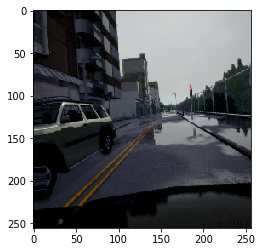

In [13]:
plt.imshow(d[0])

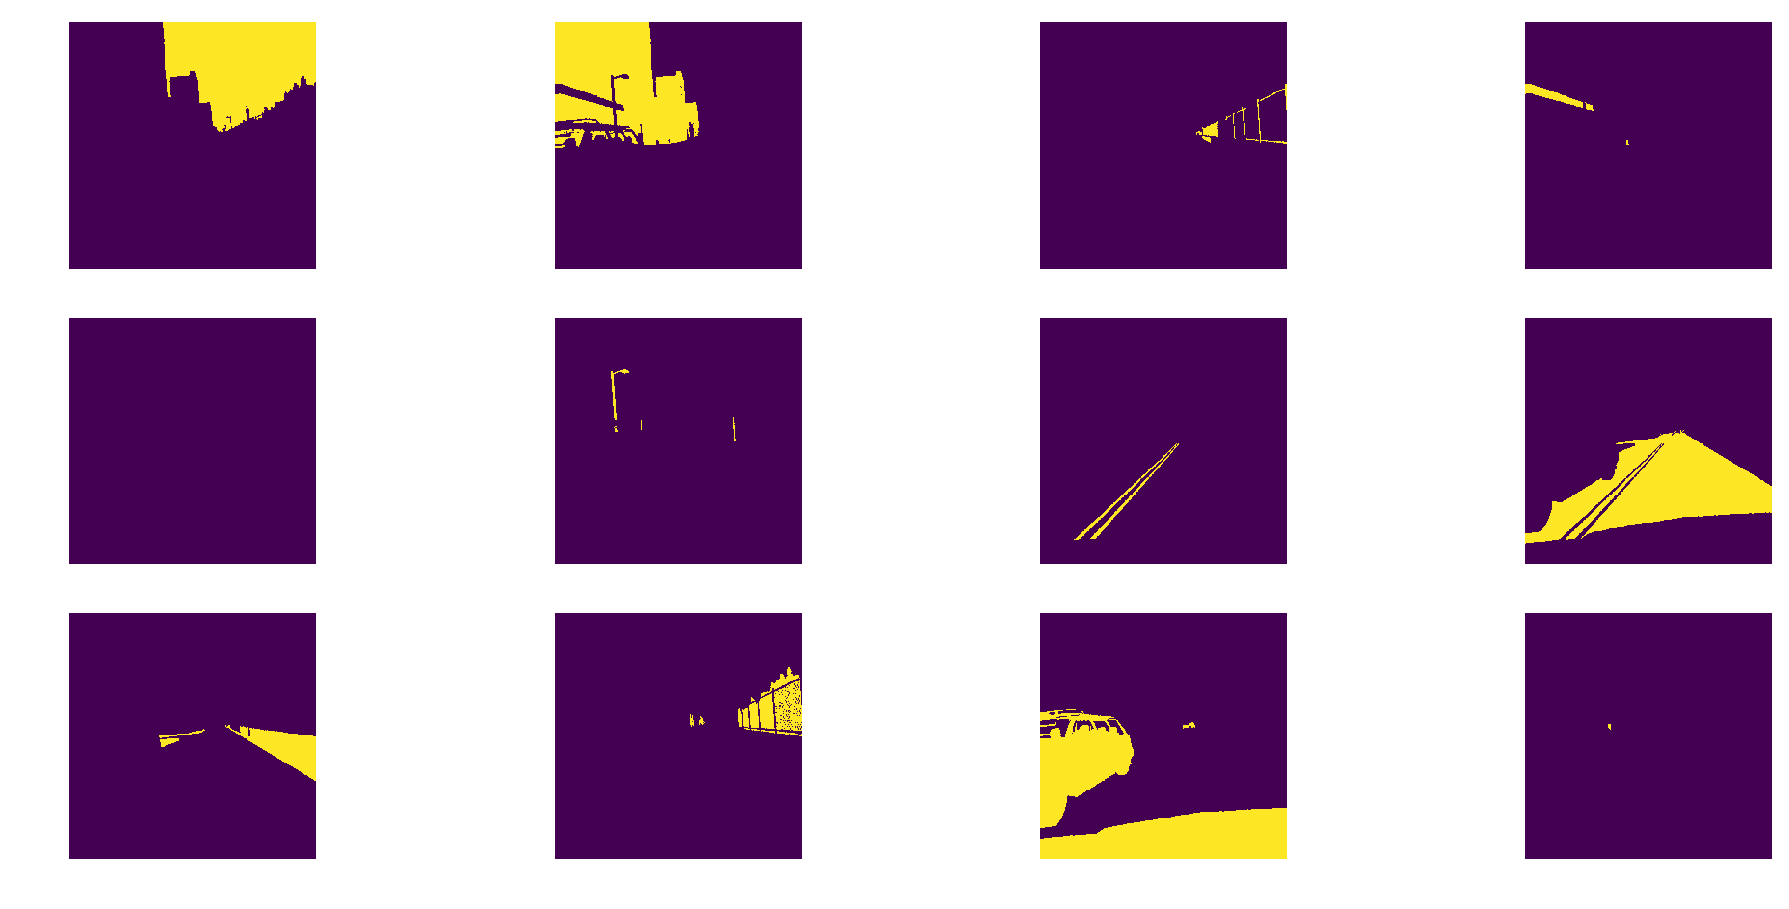

In [14]:
#Tracking how the various channels in a mask visualize
plt.figure( figsize=(16, 10), dpi=150)
for i in range(12):
    plt.subplot(4,4,i+1) 
    plt.imshow(e[0][:,:,i])
    plt.axis('off')

#### Showcasing the Effect of removing small objects:

> If small objects are not removed we would observe very small objects as anomlies in the various channels of the mask. This sections demonstrates the same.

(-0.5, 255.5, 255.5, -0.5)

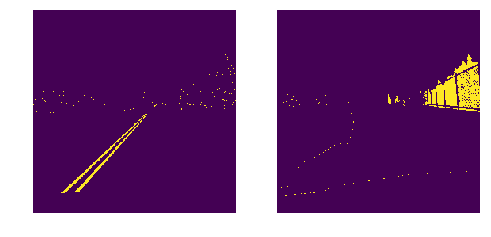

In [55]:
#This specific code was run after commenting the remove samll objects code in the generator
plt.figure(figsize = (8,4))
plt.subplot(1,2,1) 
plt.imshow(c[0][:,:,6])
plt.axis('off')
plt.subplot(1,2,2) 
plt.imshow(c[0][:,:,9])
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

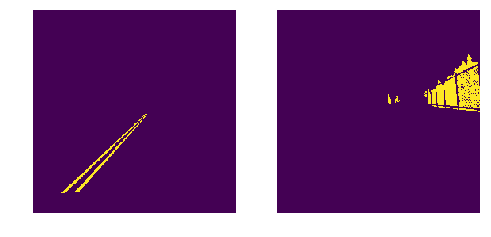

In [58]:
#after removing small objects
plt.figure(figsize = (8,4))
plt.subplot(1,2,1) 
plt.imshow(morphology.remove_small_objects((c[0][:,:,6].astype(bool)), 10, connectivity=2)*1)
plt.axis('off')
plt.subplot(1,2,2) 
plt.imshow(morphology.remove_small_objects((c[0][:,:,9].astype(bool)), 10, connectivity=2)*1)
plt.axis('off')

## FCN Model

The Fully connected Network (FCN) was the first deep learning solution that could be trained end to end for making a dense pixel prediction. 

It builds upon well known classification model VGG-16 and up-samples the output to make the prediction. 

The feature maps during up-sampling are refined by pixel-wise addition of feature maps from that of the last two layers of the classifier (encoder).

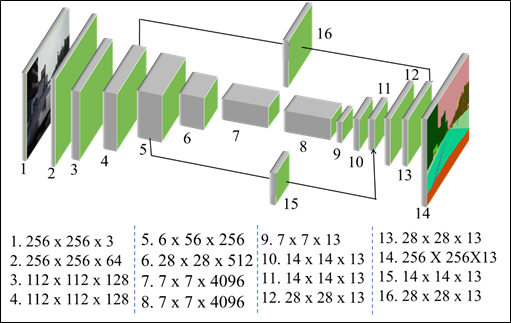

In [2]:
def blck(n_channels,n_layers,n_blck) :
    
    '''
    What this function does?
    blck function creates a block of convolution layers.
    
    Input Arguments:
    n_channels- Number of channels in the input function call
    n_blck- Number of the block; used for the layer naming convention
    n_layers- Number of convolution layers in the block
    
    Function return:
    A sequence of colvolutional layers; followed by a max-pooling layer
    '''
    Layers = []
    padding="same"
    activation="relu"
    for i in range(n_layers) :
        # Layer name is defined on the basis of the block number, it belongs to
        layer_name = "convblock"+str(n_blck)+"-layer-"+str(i+1)
        #print(layer_name)
        # A (3,3) kernel is used. Hence, (3,3) is mentioned in the second argument of the convolution2D layer definition
        Layers.append(Convolution2D(n_channels,(3,3),activation = activation,name = layer_name,padding=padding))
    
    layer_name = "convblock"+str(n_blck)+"-pool"
    
    #Addding max pooling layer
    Layers.append(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name = layer_name))
    
    return Layers

In [3]:
def FCN(input_size,n_classes,fcn_level):
    
    '''
    What this function does?
    Creates an FCN model using the blck function, coded in the previous cell of the Jupyter notebook
    
    Input Arguments:
    input_size- Takes the size/dimension of the input image-ex.(Pixels in x-direction, Pixels in y-direction, Number of channels) 
    n_classes- Number of output class
    fcn_level- Asks user about the level of upsampling/transpose convolution (it can take 8 or 16 as an argument)
    
    Function return:
    FCN model respective to the chosen level of upsampling/transpose convolution
    '''
    model = Sequential()
    model.add(Permute((1,2,3),input_shape = (input_size,input_size,3)))
    
    n_channels_list = [64, 128, 256, 512, 512]
    
    for i,j in enumerate(n_channels_list):
        
        if(i<2):
            k = 2
        else:
            k=3
            
        for layer in blck(j,k,(i+1)) :
            model.add(layer)
    
    padding="same"
    activation = 'relu'
    
    model.add(Convolution2D(4096,kernel_size=(7,7),padding=padding,activation = activation,name = "fully_conv_6"))
    model.add(Convolution2D(4096,kernel_size=(1,1),padding=padding,activation = activation,name = "fully_conv_7"))
    
    model.add(Convolution2D(n_classes,kernel_size=(1,1),padding=padding,activation=activation,name = "prediction_layer"))
    
    model.add(Deconvolution2D(n_classes,kernel_size=(4,4),strides = (2,2),padding ="valid",name = "up1"))
    #would need to be defined for a different image size
    model.add(Cropping2D(cropping=((0,2),(0,2))))
    
    o = model.get_layer('convblock4-pool').output
    
    skip1 = Convolution2D(n_classes,kernel_size=(1,1),padding =padding, name = "skip1") (o)
    added = add(inputs = [skip1, model.layers[-1].output])
    
    if(fcn_level==8):
        up2 = Deconvolution2D(n_classes,kernel_size=(4,4),strides = (2,2),padding = "valid",activation=None,name = "up2")(added)
        #would need to be defined for a different image size
        up2 = Cropping2D(cropping=((0,2),(0,2)))(up2)

        o = model.get_layer('convblock3-pool').output
        skip2 = Convolution2D(n_classes,kernel_size=(1,1),padding =padding,activation=None, name = "skip2")(o)
        added = add(inputs = [skip2,up2])

        up3 = Deconvolution2D(n_classes,kernel_size=(16,16),strides = (8,8),
                             padding = "valid",activation = None,name = "up3")(added)
        
        up3 = Cropping2D(cropping = ((0,8),(0,8)))(up3)
    
    else:
        
        up3 = Deconvolution2D(n_classes,kernel_size=(16,16),strides = (16,16),
                             padding = "valid",activation = None,name = "up3")(added)
        
    
   
    
    o = (Activation('softmax'))(up3)
    
    
    return Model(model.input, o)

In [4]:
model = FCN(256,13,8)

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
permute_1_input (InputLayer)    (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 256, 256, 3)  0           permute_1_input[0][0]            
__________________________________________________________________________________________________
convblock1-layer-1 (Conv2D)     (None, 256, 256, 64) 1792        permute_1[0][0]                  
__________________________________________________________________________________________________
convblock1-layer-2 (Conv2D)     (None, 256, 256, 64) 36928       convblock1-layer-1[0][0]         
__________________________________________________________________________________________________
convblock1

### Defining IoU  as a metric class so that it can be passed into the keras training function

IoU is defined as the ratio of overlap of the object in the target and the prediction to the union between the two.

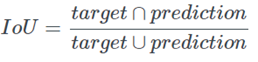

In [6]:
# The following code has been taken from [1]
class MeanIoU(object):
    """Mean intersection over union (mIoU) metric.
    Intersection over union (IoU) is a common evaluation metric for semantic
    segmentation. The predictions are first accumulated in a confusion matrix
    and the IoU is computed from it as follows:
        IoU = true_positive / (true_positive + false_positive + false_negative).
    The mean IoU is the mean of IoU between all classes.
    Keyword arguments:
        num_classes (int): number of classes in the classification problem.
    """

    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes

    def mean_iou(self, y_true, y_pred):
        """The metric function to be passed to the model.
        Args:
            y_true (tensor): True labels.
            y_pred (tensor): Predictions of the same shape as y_true.
        Returns:
            The mean intersection over union as a tensor.
        """
        # Wraps _mean_iou function and uses it as a TensorFlow op.
        # Takes numpy arrays as its arguments and returns numpy arrays as
        # its outputs.
        return tf.py_func(self._mean_iou, [y_true, y_pred], tf.float32)

    def _mean_iou(self, y_true, y_pred):
        """Computes the mean intesection over union using numpy.
        Args:
            y_true (tensor): True labels.
            y_pred (tensor): Predictions of the same shape as y_true.
        Returns:
            The mean intersection over union (np.float32).
        """
        # Compute the confusion matrix to get the number of true positives,
        # false positives, and false negatives
        # Convert predictions and target from categorical to integer format
        target = np.argmax(y_true, axis=-1).ravel()
        predicted = np.argmax(y_pred, axis=-1).ravel()

        # Trick for bincounting 2 arrays together
        x = predicted + self.num_classes * target
        bincount_2d = np.bincount(
            x.astype(np.int32), minlength=self.num_classes**2
        )
        assert bincount_2d.size == self.num_classes**2
        conf = bincount_2d.reshape(
            (self.num_classes, self.num_classes)
        )

        # Compute the IoU and mean IoU from the confusion matrix
        true_positive = np.diag(conf)
        false_positive = np.sum(conf, 0) - true_positive
        false_negative = np.sum(conf, 1) - true_positive

        # Just in case we get a division by 0, ignore/hide the error and
        # set the value to 1 since we predicted 0 pixels for that class and
        # and the batch has 0 pixels for that same class
        with np.errstate(divide='ignore', invalid='ignore'):
            iou = true_positive / (true_positive + false_positive + false_negative)
        iou[np.isnan(iou)] = 1

        return np.mean(iou).astype(np.float32)

In [7]:
#Compiling the model
miou_metric = MeanIoU(13)
model.compile(optimizer=Adam(lr=.001), loss= 'categorical_crossentropy', metrics = ['accuracy', miou_metric.mean_iou])

In [26]:
#Training the model for 20 epochs while noting down the GPU utilization and time for training for every epoch 

load1 = []
utilization1 = []
load2 = []
utilization2 = []

#Creating a Monitor
class Monitor(Thread):
    def __init__(self, delay):
        super(Monitor, self).__init__()
        self.stopped = False
        self.delay = delay # Time between calls to GPUtil
        self.start()

    def run(self):
        while not self.stopped:
            GPU = GPUtil.getGPUs()
            load1.append(GPU[0].load*100) 
            utilization1.append(GPU[0].memoryUtil*100)
            load2.append(GPU[1].load*100) 
            utilization2.append(GPU[1].memoryUtil*100)
            time.sleep(self.delay)

    def stop(self):
        self.stopped = True
        
# Instantiate monitor with a 10-second delay between updates
monitor = Monitor(10)

history1 = model.fit_generator( train_gen , 700  , epochs=20 , validation_data = valid_gen , validation_steps = 150   )
model.save( "model_FCN_categorical_with_utilization_20_epochs_2103_Morphology.h5")

# Close monitor
monitor.stop()

Epoch 1/20
700/700 [==============================] - 497s 710ms/step - loss: 0.8859 - acc: 0.6877 - mean_iou: 0.3357 - val_loss: 1.0160 - val_acc: 0.7119 - val_mean_iou: 0.3150
Epoch 2/20
700/700 [==============================] - 498s 711ms/step - loss: 0.6116 - acc: 0.7952 - mean_iou: 0.4095 - val_loss: 0.8116 - val_acc: 0.7496 - val_mean_iou: 0.3510
Epoch 3/20
700/700 [==============================] - 507s 725ms/step - loss: 0.4904 - acc: 0.8345 - mean_iou: 0.4466 - val_loss: 0.6422 - val_acc: 0.7914 - val_mean_iou: 0.4090
Epoch 4/20
700/700 [==============================] - 508s 726ms/step - loss: 0.4210 - acc: 0.8565 - mean_iou: 0.4650 - val_loss: 0.6018 - val_acc: 0.8069 - val_mean_iou: 0.4063
Epoch 5/20
700/700 [==============================] - 507s 725ms/step - loss: 0.3764 - acc: 0.8678 - mean_iou: 0.4783 - val_loss: 0.6749 - val_acc: 0.7982 - val_mean_iou: 0.3795
Epoch 6/20
700/700 [==============================] - 490s 700ms/step - loss: 0.3360 - acc: 0.8803 - mean_iou:

In [27]:
#Training the model for another 10 epochs while noting down the GPU utilization and time for training for every epoch 


load1_2 = []
utilization1_2 = []
load2_2 = []
utilization2_2 = []

# Instantiting the Monitor
class Monitor(Thread):
    def __init__(self, delay):
        super(Monitor, self).__init__()
        self.stopped = False
        self.delay = delay # Time between calls to GPUtil
        self.start()

    def run(self):
        while not self.stopped:
            GPU = GPUtil.getGPUs()
            load1_2.append(GPU[0].load*100) 
            utilization1_2.append(GPU[0].memoryUtil*100)
            load2_2.append(GPU[1].load*100) 
            utilization2_2.append(GPU[1].memoryUtil*100)
            time.sleep(self.delay)

    def stop(self):
        self.stopped = True
        
# Instantiate monitor with a 10-second delay between updates
monitor = Monitor(10)

history1 = model.fit_generator( train_gen , 700  , epochs=10 , validation_data = valid_gen , validation_steps = 150   )
model.save( "model_FCN_categorical_with_utilization_20+10_epochs_2103_Morphology.h5")

# Close monitor
monitor.stop()

Epoch 1/10
700/700 [==============================] - 490s 700ms/step - loss: 0.1255 - acc: 0.9421 - mean_iou: 0.6588 - val_loss: 0.2442 - val_acc: 0.9121 - val_mean_iou: 0.5753
Epoch 2/10
700/700 [==============================] - 484s 691ms/step - loss: 0.1196 - acc: 0.9437 - mean_iou: 0.6648 - val_loss: 0.2183 - val_acc: 0.9184 - val_mean_iou: 0.5767
Epoch 3/10
700/700 [==============================] - 486s 695ms/step - loss: 0.1171 - acc: 0.9443 - mean_iou: 0.6675 - val_loss: 0.2076 - val_acc: 0.9191 - val_mean_iou: 0.5680
Epoch 4/10
700/700 [==============================] - 480s 686ms/step - loss: 0.1181 - acc: 0.9442 - mean_iou: 0.6655 - val_loss: 0.2101 - val_acc: 0.9195 - val_mean_iou: 0.5810
Epoch 5/10
700/700 [==============================] - 491s 702ms/step - loss: 0.1116 - acc: 0.9459 - mean_iou: 0.6746 - val_loss: 0.1810 - val_acc: 0.9251 - val_mean_iou: 0.5853
Epoch 6/10
700/700 [==============================] - 486s 694ms/step - loss: 0.1091 - acc: 0.9467 - mean_iou:

In [28]:
#Saving the GPU utilization and load as csv to the disk
import pandas as pd
FCN_GPU_STATS = {'load_Gpu_1': load1+load1_2,
         'Utilization_Gpu_1': utilization1+ utilization1_2,
        'load_Gpu_2': load2+load2_2,
         'Utilization_Gpu_2': utilization2+utilization2_2}
df = pd.DataFrame.from_dict(FCN_GPU_STATS)
df.to_csv('FCN_GPU_STATS_Morphology', index=0)

In [27]:

l=[]
#extracting layer names 
for i in model.layers:
    l.append(i.name)

#defining a function that treturns the output from an intermediate layer given an input to work on and the layer name
def any_layer_output(x , output_layer_idx, filter_n):

    get_layer_output = K.function([model.layers[0].input],
                                      [model.layers[output_layer_idx].output])

    layer_output = get_layer_output([x])[0]
    layer_output = activations.softmax(tf.convert_to_tensor(layer_output, np.float32))
    output = tf.Session().run(layer_output[0][:,:,filter_n])
    return output

(-0.5, 15.5, 15.5, -0.5)

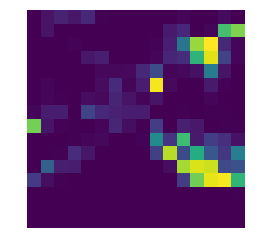

In [223]:
# Finding the feature heat map generated by the model for a side walk given an input
plt.imshow(any_layer_output(b[0][np.newaxis], l.index('prediction_layer'), 7))
plt.axis('off')

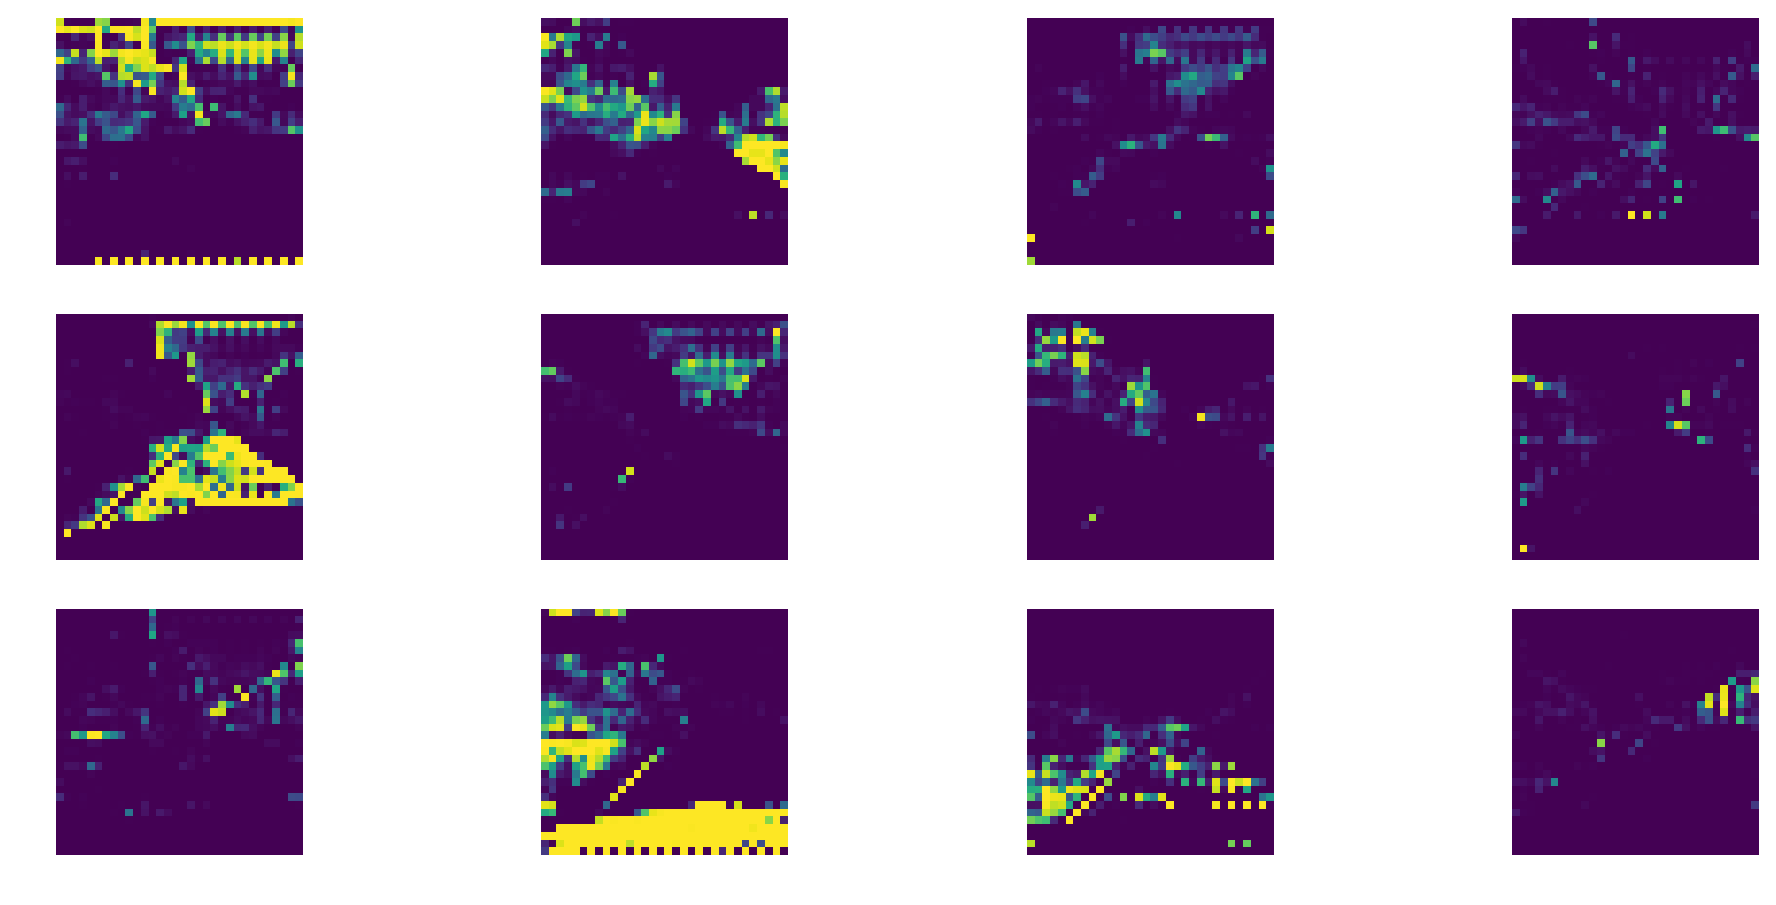

In [181]:
#Visualizing the inference made by the model after the second skip connection
plt.figure( figsize=(16, 10), dpi=150)
for i in range(12):
    plt.subplot(4,4,i+1) 
    plt.imshow(any_layer_output(b[0][np.newaxis], l.index('add_2'), i))
    plt.axis('off')

## UNet Model

U-Net extends FCN and deploys four distinct down-sampling and up-sampling stages wherein feature maps from each down-sampling layer are concatenated with corresponding up-sampling stage, thus making the up-sampling and the down-sampling streams identical, giving the algorithm its inherent U shape. 

It is claimed that the network can learn from very few images due to the large number of feature channels during up-sampling

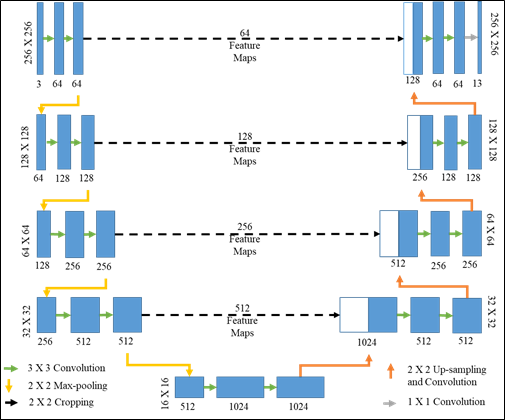

In [8]:
def Unet (img_width , img_height, n_classes): 
    
    #Input Layer
    inputs = Input(( img_width, img_height,3))
    
    kernel_initializer="he_normal"
    padding='same'
    activation='relu'
    
    #1st Stage
    conv1 = Convolution2D(64, (3, 3), activation=activation,padding=padding, kernel_initializer=kernel_initializer, name='conv1_blck1')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Convolution2D(64, (3, 3), activation=activation ,padding=padding,kernel_initializer=kernel_initializer, name='block1_conv2')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.2)(pool1)
    
    #2nd Stage
    conv2 = Convolution2D(128, (3, 3), activation=activation,padding=padding,kernel_initializer=kernel_initializer, name='block2_conv1')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Convolution2D(128, (3, 3), activation=activation,padding=padding, kernel_initializer=kernel_initializer,name='block2_conv2')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.2)(pool2)
    
    #3rd Stage
    conv3 = Convolution2D(256, (3, 3), activation=activation,padding=padding, kernel_initializer=kernel_initializer,name='block3_conv1')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Convolution2D(256, (3, 3), activation=activation,padding=padding, kernel_initializer=kernel_initializer,name='block3_conv2')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.2)(pool3)

    #4th Stage
    conv4 = Convolution2D(512, (3, 3), activation=activation,padding=padding,kernel_initializer=kernel_initializer, name='block4_conv1')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Convolution2D(512, (3, 3), activation=activation,padding=padding, kernel_initializer=kernel_initializer,name='block4_conv2')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.2)(pool4)

    #Base
    conv5 = Convolution2D(1024, (3, 3), activation=activation,padding=padding,kernel_initializer=kernel_initializer, name='block5_conv1')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Convolution2D(1024, (3, 3), activation=activation,padding=padding,kernel_initializer=kernel_initializer, name='block5_conv2')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    #Up- Stage 4
    up1 = (UpSampling2D( (2,2)))(conv5)
    upconv1 = Convolution2D(512, (3, 3), padding=padding, name='upblock1_conv1', data_format='channels_last')(up1)
    add1 = ( concatenate([ conv4 ,upconv1],axis=3 )  )
    add1 = Dropout(0.2)(add1)
    conv6 = Convolution2D(512, (3, 3), activation=activation, padding=padding,kernel_initializer=kernel_initializer, name='upblock1_conv2')(add1)
    conv6 = BatchNormalization()(conv6)
    conv6 = Convolution2D(512, (3, 3), activation=activation, padding=padding ,kernel_initializer=kernel_initializer,name='upblock1_conv3')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    #Up- Stage 3
    up2 = (UpSampling2D( (2,2)))(conv6)
    upconv2 = Convolution2D(256, (3, 3), padding=padding, name='upblock2_conv1')(up2)
    add2 = ( concatenate([ conv3 ,upconv2],axis=3 )  )
    add2 = Dropout(0.2)(add2)
    conv7 = Convolution2D(256, (3, 3), activation=activation, padding=padding, kernel_initializer=kernel_initializer,name='upblock2_conv2')(add2)
    conv7 = BatchNormalization()(conv7)
    conv7 = Convolution2D(256, (3, 3), activation=activation, padding=padding ,kernel_initializer=kernel_initializer,name='upblock2_conv3')(conv7)
    conv7 = BatchNormalization()(conv7)

    #Up- Stage 2
    up3 = (UpSampling2D( (2,2)))(conv7)
    upconv3 = Convolution2D(128, (3, 3), padding=padding, name='upblock3_conv1')(up3)
    add3 = ( concatenate([ conv2 ,upconv3],axis=3 )  )
    add3 = Dropout(0.2)(add3)
    conv8 = Convolution2D(128, (3, 3), activation=activation, padding=padding, kernel_initializer=kernel_initializer,name='upblock3_conv2')(add3)
    conv8 = BatchNormalization()(conv8)
    conv8 = Convolution2D(128, (3, 3), activation=activation, padding=padding ,kernel_initializer=kernel_initializer,name='upblock3_conv3')(conv8)
    conv8 = BatchNormalization()(conv8)

    #Up- Stage 1
    up4 = (UpSampling2D( (2,2)))(conv8)
    upconv4 = Convolution2D(64, (3, 3), padding=padding, name='upblock4_conv1')(up4)
    add4 = ( concatenate([ conv1 ,upconv4],axis=3 )  )
    add4 = Dropout(0.2)(add4)
    conv9 = Convolution2D(64, (3, 3), activation=activation, padding=padding, kernel_initializer=kernel_initializer,name='upblock4_conv2')(add4)
    conv9 = BatchNormalization()(conv9)
    conv9 = Convolution2D(64, (3, 3), activation=activation, padding=padding ,kernel_initializer=kernel_initializer,name='upblock4_conv3')(conv9)
    conv9 = BatchNormalization()(conv9)

    #Final COnvolution and Activation
    o =  Convolution2D( n_classes , (3, 3) , padding=padding)( conv9 )
    o = (Activation('softmax'))(o)
    model = Model( inputs , o )
    
    return model


In [14]:
#Conpiling the model
model1 = Unet(256,256,13) 
miou_metric = MeanIoU(13)
model1.compile(optimizer=Adam(lr=.001), loss= 'categorical_crossentropy', metrics = ['accuracy', miou_metric.mean_iou])

In [15]:
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_blck1 (Conv2D)            (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv1_blck1[0][0]                
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [55]:
#Training the model for 20 epochs while noting the GPU utilization and time taken for each epoch

load1 = []
utilization1 = []
load2 = []
utilization2 = []

#Instantiating the monitor
class Monitor(Thread):
    def __init__(self, delay):
        super(Monitor, self).__init__()
        self.stopped = False
        self.delay = delay # Time between calls to GPUtil
        self.start()

    def run(self):
        while not self.stopped:
            GPU = GPUtil.getGPUs()
            load1.append(GPU[0].load*100) 
            utilization1.append(GPU[0].memoryUtil*100)
            load2.append(GPU[1].load*100) 
            utilization2.append(GPU[1].memoryUtil*100)
            time.sleep(self.delay)

    def stop(self):
        self.stopped = True
        
# Instantiate monitor with a 10-second delay between updates
monitor = Monitor(10)

history1 = model.fit_generator( train_gen , 700  , epochs=20 , validation_data = valid_gen , validation_steps = 150   )
model1.save("model_UNET_categorical_with_utilization_20_epochs_2103_Morphology.h5")

# Close monitor
monitor.stop()

Epoch 1/20
700/700 [==============================] - 480s 685ms/step - loss: 0.5621 - acc: 0.8196 - mean_iou: 0.4612 - val_loss: 1.0681 - val_acc: 0.7345 - val_mean_iou: 0.3884
Epoch 2/20
700/700 [==============================] - 483s 690ms/step - loss: 0.4442 - acc: 0.8483 - mean_iou: 0.4971 - val_loss: 1.8374 - val_acc: 0.4349 - val_mean_iou: 0.2918
Epoch 3/20
700/700 [==============================] - 484s 692ms/step - loss: 0.4023 - acc: 0.8598 - mean_iou: 0.5096 - val_loss: 1.9245 - val_acc: 0.4521 - val_mean_iou: 0.2899
Epoch 4/20
700/700 [==============================] - 474s 677ms/step - loss: 0.3795 - acc: 0.8673 - mean_iou: 0.5183 - val_loss: 1.0991 - val_acc: 0.6850 - val_mean_iou: 0.3988
Epoch 5/20
700/700 [==============================] - 485s 694ms/step - loss: 0.3497 - acc: 0.8771 - mean_iou: 0.5259 - val_loss: 0.8475 - val_acc: 0.7238 - val_mean_iou: 0.4236
Epoch 6/20
700/700 [==============================] - 489s 699ms/step - loss: 0.3288 - acc: 0.8838 - mean_iou:

In [56]:
#Training the model for another 10 epochs while noting the GPU utilization and time taken for each epoch


load1_2 = []
utilization1_2 = []
load2_2 = []
utilization2_2 = []

#Instantiating the monitor
class Monitor(Thread):
    def __init__(self, delay):
        super(Monitor, self).__init__()
        self.stopped = False
        self.delay = delay # Time between calls to GPUtil
        self.start()

    def run(self):
        while not self.stopped:
            GPU = GPUtil.getGPUs()
            load1_2.append(GPU[0].load*100) 
            utilization1_2.append(GPU[0].memoryUtil*100)
            load2_2.append(GPU[1].load*100) 
            utilization2_2.append(GPU[1].memoryUtil*100)
            time.sleep(self.delay)

    def stop(self):
        self.stopped = True
        
# Instantiate monitor with a 10-second delay between updates
monitor = Monitor(10)

history1 = model.fit_generator( train_gen , 700  , epochs=10 , validation_data = valid_gen , validation_steps = 150   )
model1.save("model_UNET_categorical_with_utilization_20+10_epochs_2103_Morphology.h5")

# Close monitor
monitor.stop()

Epoch 1/10
700/700 [==============================] - 481s 687ms/step - loss: 0.1665 - acc: 0.9358 - mean_iou: 0.6077 - val_loss: 0.5694 - val_acc: 0.8472 - val_mean_iou: 0.4833
Epoch 2/10
700/700 [==============================] - 485s 693ms/step - loss: 0.1602 - acc: 0.9376 - mean_iou: 0.6080 - val_loss: 0.5326 - val_acc: 0.8456 - val_mean_iou: 0.4848
Epoch 3/10
700/700 [==============================] - 487s 695ms/step - loss: 0.1518 - acc: 0.9403 - mean_iou: 0.6145 - val_loss: 0.7335 - val_acc: 0.8110 - val_mean_iou: 0.4829
Epoch 4/10
700/700 [==============================] - 478s 683ms/step - loss: 0.1458 - acc: 0.9421 - mean_iou: 0.6178 - val_loss: 0.4823 - val_acc: 0.8541 - val_mean_iou: 0.4938
Epoch 5/10
700/700 [==============================] - 482s 689ms/step - loss: 0.1393 - acc: 0.9445 - mean_iou: 0.6230 - val_loss: 0.4035 - val_acc: 0.8809 - val_mean_iou: 0.5276
Epoch 6/10
700/700 [==============================] - 472s 674ms/step - loss: 0.1336 - acc: 0.9462 - mean_iou:

In [57]:
#Saving the GPU utilzation as a csv to the disk
import pandas as pd
UNET_GPU_STATS = {'load_Gpu_1': load1+load1_2,
         'Utilization_Gpu_1': utilization1+ utilization1_2,
        'load_Gpu_2': load2+load2_2,
         'Utilization_Gpu_2': utilization2+utilization2_2}
df = pd.DataFrame.from_dict(UNET_GPU_STATS)
df.to_csv('UNET_GPU_STATS_Morphology', index=0)

# ENet Model

ENet (efficient neural network) has been specifically created for tasks requiring low latency operations. It is claimed to be 18 times faster and having 79 times less parameters than other image segmentation architectures, while providing similar or better accuracy. 

Instead of having skip connections running form the encoder and the decoder the algorithm constitutes of various bottlenecks wherein the input of the bottleneck is added to the output as a skip connection.

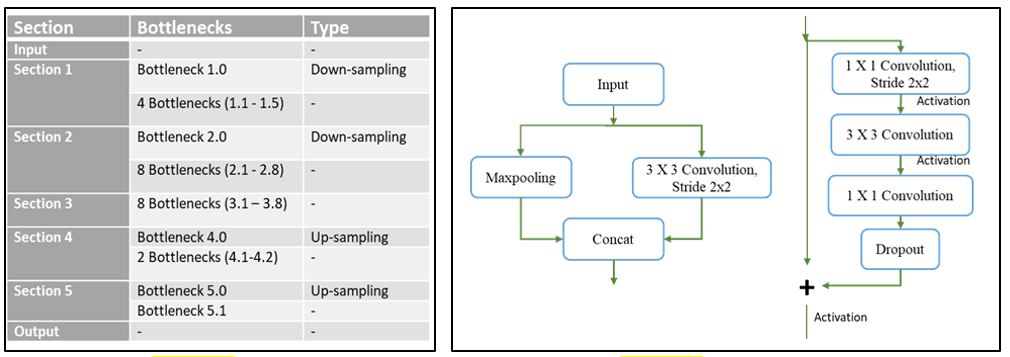

In [16]:
#Encoder
def downsample_bottleneck(o, output_size , asymmetric=0, dilated=0, downsample=0):

    second_branch = o
    input_n_channels = o.get_shape().as_list()[3]
    padding = output_size - input_n_channels
    
    # reducing the channels (1x1)
    if downsample:
        stride = 2
    else:
        stride =1
    
    o = Conv2D(output_size//4, (stride, stride),strides=(stride, stride), use_bias=False)(o)
    o = BatchNormalization(momentum=0.1)(o) 
    o = PReLU(shared_axes=[1, 2])(o)

    # Perfroming convolution (COnv) 
    if asymmetric: 
        o = Conv2D(output_size//4, (1, asymmetric), padding='same', use_bias=False)(o)
        o = Conv2D(output_size//4, (asymmetric, 1), padding='same')(o)
    else:
        if dilated:
            o = Conv2D(output_size//4, (3, 3), dilation_rate=(dilated, dilated), padding='same')(o)
        else:
            o = Conv2D(output_size//4, (3, 3), padding='same')(o)
            
    o = BatchNormalization(momentum=0.1)(o) 
    o = PReLU(shared_axes=[1, 2])(o)

    # Producing back the channels (1x1) 
    o = Conv2D(output_size, (1, 1), use_bias=False)(o)
    o = BatchNormalization(momentum=0.1)(o)  
    
    # Performing regularization (Regularizer)
    o = SpatialDropout2D(0.1)(o)

    # Second branch
    
    #performing max pooling only if downsample
    if downsample:
        second_branch = MaxPooling2D()(second_branch)
    
        #performing padding -- only required if downsampling
        second_branch = Permute((1, 3, 2))(second_branch)
        second_branch = ZeroPadding2D(padding=((0, 0), (0, padding)))(second_branch)
        second_branch = Permute((1, 3, 2))(second_branch)

    o = add([o, second_branch])
    o = PReLU(shared_axes=[1, 2])(o)

    return o

In [17]:
# decoder
def upsample_bottleneck(o, output_size, upsample=0):
    
    other_branch = o
    
    o = Conv2D(output_size//4, (1, 1), use_bias=False)(o)
    o = BatchNormalization(momentum=0.1)(o)
    o = Activation('relu')(o)
    
    #Applyting transpose convolution if upsampling
    if upsample:
        o = Conv2DTranspose(output_size//4, kernel_size=(3, 3), strides=(2, 2), padding='same')(o)
    else:
        o = Conv2D(output_size//4, (3, 3), padding='same', use_bias=True)(o)
        
    o = BatchNormalization(momentum=0.1)(o)
    o = Activation('relu')(o)

    o = Conv2D(output_size, (1, 1), padding='same', use_bias=False)(o)

    # upsampling the other branch as well
    if upsample:
            other_branch = Conv2D(output_size, (1, 1), padding='same', use_bias=False)(other_branch)
            other_branch = BatchNormalization(momentum=0.1)(other_branch)
            other_branch = UpSampling2D(size=(2, 2))(other_branch)


    o = BatchNormalization(momentum=0.1)(o)
    o = add([o, other_branch])
    o = Activation('relu')(o)

    return o

In [18]:
# Defining the model
def ENet(n_classes, input_height, input_width):
    
    img_input = Input(shape=(input_height, input_width, 3))
    
    
    ## Section Initial
    conv = Conv2D(13, (3, 3), padding='same', strides=(2,2))(img_input)
    max_pool = MaxPooling2D()(img_input)
    merged = concatenate([conv, max_pool], axis=3)
    o = BatchNormalization(momentum=0.1)(merged)
    o = PReLU(shared_axes=[1, 2])(o)
    ### Section Initial End
    
    ##Section 2 and 3 
    o = downsample_bottleneck(o, 64, downsample=True) # 1.1
    
    for _ in range(4): #1.2-1.5
        o = downsample_bottleneck(o, 64)

    o = downsample_bottleneck(o, 128, downsample=True) #2.0
    
    for _ in range(2):
        o = downsample_bottleneck(o, 128)  # 2.1
        o = downsample_bottleneck(o, 128, dilated=2)  # 2.2
        o = downsample_bottleneck(o, 128, asymmetric=5)  #2.3
        o = downsample_bottleneck(o, 128, dilated=4)  # 2.4
        o = downsample_bottleneck(o, 128)  # 2.5
        o = downsample_bottleneck(o, 128, dilated=8)  # 2.6
        o = downsample_bottleneck(o, 128, asymmetric=5)  # 2.7
        o = downsample_bottleneck(o, 128, dilated=16)  # 2.8
     
    ## Section 2 and 3 end
    
    
    ## Section 4
    o = upsample_bottleneck(o, 64, upsample=True)  # 4.0
    o = upsample_bottleneck(o, 64)  # 4.1
    o = upsample_bottleneck(o, 64)  # 4.2
    # Section 4 ends
    
    #Section 5 
    o = upsample_bottleneck(o, 16, upsample=True)  # bottleneck 5.0
    o = upsample_bottleneck(o, 16)  # bottleneck 5.1
    #section 5 ends

    o = Conv2DTranspose(filters=n_classes, kernel_size=(2, 2), strides=(2, 2), padding='same')(o)

    o = Activation('softmax')(o)
    model = Model(img_input, o)
    
    return model

In [19]:
#Compiling the model
model2 = ENet(13, 256, 256)

miou_metric = MeanIoU(13)
model2.compile(optimizer=Adam(lr=.001), loss= 'categorical_crossentropy', metrics = ['accuracy', miou_metric.mean_iou])

In [20]:
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 13) 364         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 128, 128, 16) 0           conv2d_2[0][0]                   
                                                                 max_pooling2d_5[0][0]            
__________

In [86]:
#Training the model for 20 epochs while noting the GPU utilization and time taken for each epoch


load1 = []
utilization1 = []
load2 = []
utilization2 = []

#Instantiating the monitor
class Monitor(Thread):
    def __init__(self, delay):
        super(Monitor, self).__init__()
        self.stopped = False
        self.delay = delay # Time between calls to GPUtil
        self.start()

    def run(self):
        while not self.stopped:
            GPU = GPUtil.getGPUs()
            load1.append(GPU[0].load*100) 
            utilization1.append(GPU[0].memoryUtil*100)
            load2.append(GPU[1].load*100) 
            utilization2.append(GPU[1].memoryUtil*100)
            time.sleep(self.delay)

    def stop(self):
        self.stopped = True
        
# Instantiate monitor with a 10-second delay between updates
monitor = Monitor(10)

history1 = model.fit_generator( train_gen , 700  , epochs=20 , validation_data = valid_gen , validation_steps = 150   )
model2.save("model_ENET_categorical_with_utilization_20_epochs_2103_Morphological.h5")

# Close monitor
monitor.stop()

Epoch 1/20
700/700 [==============================] - 422s 603ms/step - loss: 0.7489 - acc: 0.7772 - mean_iou: 0.3290 - val_loss: 0.6972 - val_acc: 0.7763 - val_mean_iou: 0.3078
Epoch 2/20
700/700 [==============================] - 409s 584ms/step - loss: 0.4858 - acc: 0.8512 - mean_iou: 0.3828 - val_loss: 0.5715 - val_acc: 0.8148 - val_mean_iou: 0.3430
Epoch 3/20
700/700 [==============================] - 402s 574ms/step - loss: 0.4310 - acc: 0.8675 - mean_iou: 0.3996 - val_loss: 0.5147 - val_acc: 0.8294 - val_mean_iou: 0.3659
Epoch 4/20
700/700 [==============================] - 399s 570ms/step - loss: 0.3973 - acc: 0.8781 - mean_iou: 0.4081 - val_loss: 0.5137 - val_acc: 0.8294 - val_mean_iou: 0.3775
Epoch 5/20
700/700 [==============================] - 409s 584ms/step - loss: 0.3653 - acc: 0.8891 - mean_iou: 0.4216 - val_loss: 0.5174 - val_acc: 0.8303 - val_mean_iou: 0.3855
Epoch 6/20
700/700 [==============================] - 404s 577ms/step - loss: 0.3399 - acc: 0.8973 - mean_iou:

In [87]:
#Training the model for another 10 epochs while noting the GPU utilization and time taken for each epoch

load1_2 = []
utilization1_2 = []
load2_2 = []
utilization2_2 = []

#Instantiating the monitor
class Monitor(Thread):
    def __init__(self, delay):
        super(Monitor, self).__init__()
        self.stopped = False
        self.delay = delay # Time between calls to GPUtil
        self.start()

    def run(self):
        while not self.stopped:
            GPU = GPUtil.getGPUs()
            load1_2.append(GPU[0].load*100) 
            utilization1_2.append(GPU[0].memoryUtil*100)
            load2_2.append(GPU[1].load*100) 
            utilization2_2.append(GPU[1].memoryUtil*100)
            time.sleep(self.delay)

    def stop(self):
        self.stopped = True
        
# Instantiate monitor with a 10-second delay between updates
monitor = Monitor(10)

history1 = model.fit_generator( train_gen , 700  , epochs=10 , validation_data = valid_gen , validation_steps = 150   )
model2.save( "model_ENET_categorical_with_utilization_20+10_epochs_2103_Morphological.h5")

# Close monitor
monitor.stop()

Epoch 1/10
700/700 [==============================] - 405s 578ms/step - loss: 0.1880 - acc: 0.9401 - mean_iou: 0.5688 - val_loss: 0.3483 - val_acc: 0.8971 - val_mean_iou: 0.4837
Epoch 2/10
700/700 [==============================] - 412s 588ms/step - loss: 0.1865 - acc: 0.9405 - mean_iou: 0.5695 - val_loss: 0.3445 - val_acc: 0.8967 - val_mean_iou: 0.4878
Epoch 3/10
700/700 [==============================] - 408s 582ms/step - loss: 0.1832 - acc: 0.9414 - mean_iou: 0.5736 - val_loss: 0.3637 - val_acc: 0.8951 - val_mean_iou: 0.4923
Epoch 4/10
700/700 [==============================] - 415s 593ms/step - loss: 0.1818 - acc: 0.9419 - mean_iou: 0.5752 - val_loss: 0.3536 - val_acc: 0.8942 - val_mean_iou: 0.4890
Epoch 5/10
700/700 [==============================] - 406s 580ms/step - loss: 0.1858 - acc: 0.9404 - mean_iou: 0.5727 - val_loss: 0.3258 - val_acc: 0.9032 - val_mean_iou: 0.4990
Epoch 6/10
700/700 [==============================] - 407s 582ms/step - loss: 0.1760 - acc: 0.9432 - mean_iou:

In [88]:
#Saving the GPU Utilization as a csv to the disk
ENET_GPU_STATS = {'load_Gpu_1': load1+load1_2,
         'Utilization_Gpu_1': utilization1+ utilization1_2,
        'load_Gpu_2': load2+load2_2,
         'Utilization_Gpu_2': utilization2+utilization2_2}
df = pd.DataFrame.from_dict(ENET_GPU_STATS)
df.to_csv('ENET_GPU_STATS_Morphological', index=0)

# Implementation of CRFasRNN Model

The last algorithm is Conditional Random Field as Recurrent Neural Network, also known as CRFasRNN. CRFs have been used widely as post processor in computer vision to refine coarse outputs. They not only penalize the false predictions of a pixel (unary predictions) but also penalizes the model if two identical looking neighboring pixels are allocated different classes. (pairwise loss). However, it is required to tune CRFs separate to the algorithm. Authors of this work present a way to convert CRF into RNNs and thus train them in conjunction with the algorithm. 

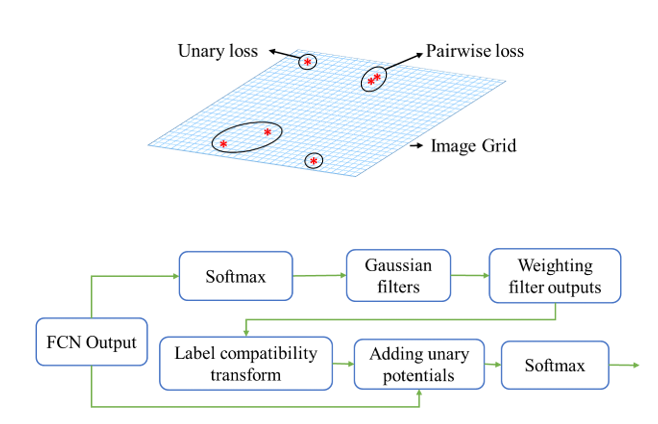

> **The code for crfrnn layer has been sourced from the github librarry of the authors [2]**

In [15]:
# The same code of FCN is used which is appended with the CRF layer  

def blck(n_channels,n_layers,n_blck) :
    
    '''
    What this function does?
    blck function creates a block of convolution layers.
    
    Input Arguments:
    n_channels- Number of channels in the input function call
    n_blck- Number of the block; used for the layer naming convention
    n_layers- Number of convolution layers in the block
    
    Function return:
    A sequence of colvolutional layers; followed by a max-pooling layer
    '''
    Layers = []
    padding="same"
    activation="relu"
    for i in range(n_layers) :
        # Layer name is defined on the basis of the block number, it belongs to
        layer_name = "convblock"+str(n_blck)+"-layer-"+str(i+1)
        #print(layer_name)
        # A (3,3) kernel is used. Hence, (3,3) is mentioned in the second argument of the convolution2D layer definition
        Layers.append(Convolution2D(n_channels,(3,3),activation = activation,name = layer_name,padding=padding))
    
    layer_name = "convblock"+str(n_blck)+"-pool"
    
    #Addding max pooling layer
    Layers.append(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name = layer_name))
    
    return Layers

In [16]:
def CRF(input_size,n_classes,fcn_level, theta):
    
    '''
    What this function does?
    Creates an FCN model using the blck function, coded in the previous cell of the Jupyter notebook
    
    Input Arguments:
    input_size- Takes the size/dimension of the input image-ex.(Pixels in x-direction, Pixels in y-direction, Number of channels) 
    n_classes- Number of output class
    fcn_level- Asks user about the level of upsampling/transpose convolution (it can take 8 or 16 as an argument)
    
    Function return:
    FCN model respective to the chosen level of upsampling/transpose convolution
    '''
    model = Sequential()
    model.add(Permute((1,2,3),input_shape = (input_size,input_size,3)))
    
    n_channels_list = [64, 128, 256, 512, 512]
    
    for i,j in enumerate(n_channels_list):
        
        if(i<2):
            k = 2
        else:
            k=3
            
        for layer in blck(j,k,(i+1)) :
            model.add(layer)
    
    padding="same"
    activation = 'relu'
    
    model.add(Convolution2D(4096,kernel_size=(7,7),padding=padding,activation = activation,name = "fully_conv_6"))
    model.add(Convolution2D(4096,kernel_size=(1,1),padding=padding,activation = activation,name = "fully_conv_7"))
    
    model.add(Convolution2D(n_classes,kernel_size=(1,1),padding=padding,activation=activation,name = "prediction_layer"))
    
    model.add(Deconvolution2D(n_classes,kernel_size=(4,4),strides = (2,2),padding ="valid",name = "up1"))
    #would need to be defined for a different image size
    model.add(Cropping2D(cropping=((0,2),(0,2))))
    
    o = model.get_layer('convblock4-pool').output
    
    skip1 = Convolution2D(n_classes,kernel_size=(1,1),padding =padding, name = "skip1") (o)
    added = add(inputs = [skip1, model.layers[-1].output])
    
    if(fcn_level==8):
        up2 = Deconvolution2D(n_classes,kernel_size=(4,4),strides = (2,2),padding = "valid",activation=None,name = "up2")(added)
        #would need to be defined for a different image size
        up2 = Cropping2D(cropping=((0,2),(0,2)))(up2)

        o = model.get_layer('convblock3-pool').output
        skip2 = Convolution2D(n_classes,kernel_size=(1,1),padding =padding,activation=None, name = "skip2")(o)
        added = add(inputs = [skip2,up2])

        up3 = Deconvolution2D(n_classes,kernel_size=(16,16),strides = (8,8),
                             padding = "valid",activation = None,name = "up3")(added)
        
        up3 = Cropping2D(cropping = ((0,8),(0,8)))(up3)
    
    else:
        
        up3 = Deconvolution2D(n_classes,kernel_size=(16,16),strides = (16,16),
                             padding = "valid",activation = None,name = "up3")(added)
    
    
    output = CrfRnnLayer(image_dims=(256,256),
                         num_classes=13,
                         theta_alpha=theta[0],
                         theta_beta=theta[1],
                         theta_gamma=theta[2],
                         num_iterations=10,
                         name='crfrnn')([up3, model.input])      
    
    o = (Activation('softmax'))(output)
    
    return Model(model.input, o)

In [17]:
model3 = CRF(256,13, 8, (160.,3.,3.))

In [18]:
model3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
permute_1_input (InputLayer)    (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 256, 256, 3)  0           permute_1_input[0][0]            
__________________________________________________________________________________________________
convblock1-layer-1 (Conv2D)     (None, 256, 256, 64) 1792        permute_1[0][0]                  
__________________________________________________________________________________________________
convblock1-layer-2 (Conv2D)     (None, 256, 256, 64) 36928       convblock1-layer-1[0][0]         
__________________________________________________________________________________________________
convblock1

In [20]:
#Compiling the model
miou_metric = MeanIoU(13)
model3.compile(optimizer=Adam(lr=.001), loss= 'categorical_crossentropy', metrics = ['accuracy', miou_metric.mean_iou])

In [21]:
#Training the model for 5 epochs with double the generter steps while noting the GPU utilization and time taken for each epoch

load1 = []
utilization1 = []
load2 = []
utilization2 = []

#Instantiating the monitor
class Monitor(Thread):
    def __init__(self, delay):
        super(Monitor, self).__init__()
        self.stopped = False
        self.delay = delay # Time between calls to GPUtil
        self.start()

    def run(self):
        while not self.stopped:
            GPU = GPUtil.getGPUs()
            load1.append(GPU[0].load*100) 
            utilization1.append(GPU[0].memoryUtil*100)
            load2.append(GPU[1].load*100) 
            utilization2.append(GPU[1].memoryUtil*100)
            time.sleep(self.delay)

    def stop(self):
        self.stopped = True
        
# Instantiate monitor with a 10-second delay between updates
monitor = Monitor(10)

history1 = model3.fit_generator( train_gen , 7000  , epochs=5 , validation_data = valid_gen , validation_steps = 1500   )
model.save( "model_CRF_categorical_with_utilization_5_epochs_23103_Morphology_activation.h5")

# Close monitor
monitor.stop()

Epoch 1/5
7000/7000 [==============================] - 4236s 605ms/step - loss: 0.3296 - acc: 0.8818 - mean_iou: 0.5479 - val_loss: 0.5986 - val_acc: 0.8197 - val_mean_iou: 0.4192
Epoch 2/5
7000/7000 [==============================] - 4207s 601ms/step - loss: 0.2054 - acc: 0.9202 - mean_iou: 0.6187 - val_loss: 0.6177 - val_acc: 0.8292 - val_mean_iou: 0.4532
Epoch 3/5
7000/7000 [==============================] - 4238s 605ms/step - loss: 0.1745 - acc: 0.9296 - mean_iou: 0.6494 - val_loss: 0.4737 - val_acc: 0.8607 - val_mean_iou: 0.4908
Epoch 4/5
7000/7000 [==============================] - 4219s 603ms/step - loss: 0.1575 - acc: 0.9344 - mean_iou: 0.6669 - val_loss: 0.4130 - val_acc: 0.8709 - val_mean_iou: 0.5151
Epoch 5/5
7000/7000 [==============================] - 4249s 607ms/step - loss: 0.1487 - acc: 0.9371 - mean_iou: 0.6769 - val_loss: 0.3899 - val_acc: 0.8777 - val_mean_iou: 0.5260


In [79]:
#Training the model for 5 epochs with double the generter steps while noting the GPU utilization and time taken for each epoch

load1_2 = []
utilization1_2 = []
load2_2 = []
utilization2_2 = []

#Instantiating the monitor
class Monitor(Thread):
    def __init__(self, delay):
        super(Monitor, self).__init__()
        self.stopped = False
        self.delay = delay # Time between calls to GPUtil
        self.start()

    def run(self):
        while not self.stopped:
            GPU = GPUtil.getGPUs()
            load1_2.append(GPU[0].load*100) 
            utilization1_2.append(GPU[0].memoryUtil*100)
            load2_2.append(GPU[1].load*100) 
            utilization2_2.append(GPU[1].memoryUtil*100)
            time.sleep(self.delay)

    def stop(self):
        self.stopped = True
        
# Instantiate monitor with a 10-second delay between updates
monitor = Monitor(10)

history1 = model.fit_generator( train_gen , 7000  , epochs=5 , validation_data = valid_gen , validation_steps = 1500   )
model3.save( "model_CRF_categorical_with_utilization_5+5_epochs_23103_Morphology_activation.h5")

# Close monitor
monitor.stop()

Epoch 1/5
7000/7000 [==============================] - 4237s 605ms/step - loss: 0.1369 - acc: 0.9402 - mean_iou: 0.6896 - val_loss: 0.3498 - val_acc: 0.8889 - val_mean_iou: 0.5556
Epoch 2/5
7000/7000 [==============================] - 4199s 600ms/step - loss: 0.1274 - acc: 0.9426 - mean_iou: 0.7000 - val_loss: 0.3593 - val_acc: 0.8941 - val_mean_iou: 0.5660
Epoch 3/5
7000/7000 [==============================] - 4235s 605ms/step - loss: 0.1231 - acc: 0.9440 - mean_iou: 0.7065 - val_loss: 0.4263 - val_acc: 0.8818 - val_mean_iou: 0.5582
Epoch 4/5
7000/7000 [==============================] - 4206s 601ms/step - loss: 0.1179 - acc: 0.9456 - mean_iou: 0.7137 - val_loss: 0.2430 - val_acc: 0.9128 - val_mean_iou: 0.6029
Epoch 5/5
7000/7000 [==============================] - 4221s 603ms/step - loss: 0.1132 - acc: 0.9472 - mean_iou: 0.7202 - val_loss: 0.2442 - val_acc: 0.9145 - val_mean_iou: 0.6065


In [80]:
#Training the model for 5 epochs with double the generter steps while noting the GPU utilization and time taken for each epoch

load1_3 = []
utilization1_3 = []
load2_3 = []
utilization2_3 = []

#Instantiating the monitor
class Monitor(Thread):
    def __init__(self, delay):
        super(Monitor, self).__init__()
        self.stopped = False
        self.delay = delay # Time between calls to GPUtil
        self.start()

    def run(self):
        while not self.stopped:
            GPU = GPUtil.getGPUs()
            load1_3.append(GPU[0].load*100) 
            utilization1_3.append(GPU[0].memoryUtil*100)
            load2_3.append(GPU[1].load*100) 
            utilization2_3.append(GPU[1].memoryUtil*100)
            time.sleep(self.delay)

    def stop(self):
        self.stopped = True
        
# Instantiate monitor with a 10-second delay between updates
monitor = Monitor(10)

history1 = model.fit_generator( train_gen , 7000  , epochs=5 , validation_data = valid_gen , validation_steps = 1500   )
model3.save( "model_CRF_categorical_with_utilization_5+5+5_epochs_23103_Morphology_activation.h5")

# Close monitor
monitor.stop()

Epoch 1/5
7000/7000 [==============================] - 4212s 602ms/step - loss: 0.1128 - acc: 0.9469 - mean_iou: 0.7201 - val_loss: 0.2571 - val_acc: 0.9111 - val_mean_iou: 0.6033
Epoch 2/5
7000/7000 [==============================] - 4204s 601ms/step - loss: 0.1085 - acc: 0.9481 - mean_iou: 0.7259 - val_loss: 0.2489 - val_acc: 0.9134 - val_mean_iou: 0.6073
Epoch 3/5
7000/7000 [==============================] - 4216s 602ms/step - loss: 0.1043 - acc: 0.9494 - mean_iou: 0.7308 - val_loss: 0.2947 - val_acc: 0.9027 - val_mean_iou: 0.5850
Epoch 4/5
7000/7000 [==============================] - 4205s 601ms/step - loss: 0.1083 - acc: 0.9481 - mean_iou: 0.7259 - val_loss: 0.2452 - val_acc: 0.9150 - val_mean_iou: 0.6052
Epoch 5/5
7000/7000 [==============================] - 4204s 601ms/step - loss: 0.1281 - acc: 0.9435 - mean_iou: 0.7130 - val_loss: 0.2129 - val_acc: 0.9208 - val_mean_iou: 0.6197


In [81]:
#Saving GPU Utilization stats as a csv to the disk
FCN_GPU_STATS = {'load_Gpu_1': load1+load1_2+load1_3,
         'Utilization_Gpu_1': utilization1+ utilization1_2+utilization1_3,
        'load_Gpu_2': load2+load2_2+load2_3,
         'Utilization_Gpu_2': utilization2+utilization2_2+utilization2_3}
df = pd.DataFrame.from_dict(FCN_GPU_STATS)
df.to_csv('CRF_GPU_STATS_Morphology', index=0)

# Evaluation of Models

Given the memory constarint all the four models could not be loaded at the same time. Therefore, FCN, UNet and ENET were evaluated together and CRFasRNN later using the same code

In [21]:
#Loading the saved weights from the disk
model.load_weights('model_FCN_categorical_with_utilization_20+10_epochs_2103_Morphology.h5')
model1.load_weights('model_UNET_categorical_with_utilization_20+10_epochs_2503_Morphology.h5')
model2.load_weights('model_ENET_categorical_with_utilization_20+10_epochs_2103_Morphological.h5')

In [33]:
#The following function returns the classwise Iou for an image

def calc_metric(num_classes, y_true, y_pred):
    
    target = np.argmax(y_true, axis=-1).ravel()
    predicted = np.argmax(y_pred, axis=-1).ravel()

    x = predicted + num_classes * target
    
    bincount_2d = np.bincount(x.astype(np.int32), minlength=num_classes**2)
    
    assert bincount_2d.size == num_classes**2
    
    conf = bincount_2d.reshape((num_classes, num_classes))
    #print(conf)
    
    true_positive = np.diag(conf)
    false_positive = np.sum(conf, 0) - true_positive
    false_negative = np.sum(conf, 1) - true_positive
    
    # Just in case we get a division by 0, ignore/hide the error and set the value to 0
    with np.errstate(divide='ignore', invalid='ignore'):
        iou = true_positive / (true_positive + false_positive + false_negative)
    
    iou[np.isnan(iou)] = 0
    
    return (iou.astype(np.float32))

In [34]:
'''
Functions to read images and mask are created again. This is because it is required to pass a 
single image and have it in the form that it can be set as an input to the model.

The Generator provides images sequentially from the diska nd therefore cnnot be used for evaluating a specific image.

'''

#The function reads an image from the disk and applies the required transformations. 
def read_img(original_path):
    img = cv2.imread(original_path)[:,:,::-1]
    img = img.astype(np.float32)
    img = img/255.0
    img = cv2.resize(img, ( 256 , 256 ),interpolation=cv2.INTER_NEAREST)
    
    return img

#The function reads an masks from the disk and applies the required transformations. 
def read_mask(mask_path):
    mask2 = cv2.imread(mask_path)
    mask2 = cv2.resize(mask2, ( 256 , 256 ),interpolation=cv2.INTER_NEAREST)[:,:,2]
    mask = np.zeros((  256 , 256  , 13))
       
    for c,l in enumerate(labels):
        mask[: , : , c ] = ((mask2 == l))*1
        mask[: , : , c ] = morphology.remove_small_objects(mask[: , : , c ].astype(bool), 10, connectivity=2)*1

    mask = mask.astype(np.float32)
    
    return mask
    

In [28]:
#Defining an RGB color for each class label
colors = [(192, 128, 128),
            (0, 64, 0),
            (128, 64, 0),
            (0, 192, 0),
            (128, 192, 0),
            (0, 64, 128),
            (128, 64, 128),
            (0, 192, 128),
            (128, 192, 128),
            (64, 64, 0),
            (192, 64, 0),
            (64, 192, 0),
            (192, 192, 0)]

In [29]:
'''
The function converts the masks and predictions of the form of image_width x image height X number of classes to  

image_width x image height X 3.

It also allocates a specfic rgb color to each label as described by the color list

'''
def prediction_visualization(prediction, mask):

    m=mask.argmax(axis=2)
    p=prediction.argmax(axis=2)
    mask_new = np.zeros((mask.shape[0], mask.shape[1], 3)) 
    prediction_new = np.zeros((mask.shape[0], mask.shape[1], 3)) 

    for c in range(13):
        mask_new[:,:,0] += ( (m[:,: ] == c )*( colors[c][0] )).astype('uint8')
        prediction_new[:,:,0] += ( (p[:,: ] == c )*( colors[c][0] )).astype('uint8')

        mask_new[:,:,1] += ((m[:,: ] == c )*( colors[c][1] )).astype('uint8')
        prediction_new[:,:,1] += ( (p[:,: ] == c )*( colors[c][1] )).astype('uint8')

        mask_new[:,:,2] += ((m[:,: ] == c )*( colors[c][2] )).astype('uint8')
        prediction_new[:,:,2] += ( (p[:,: ] == c )*( colors[c][2] )).astype('uint8')

    return mask_new.astype(np.uint8),prediction_new.astype(np.uint8)
    

In [14]:
#Calculating the classwise IoU for each testing image for each model

import warnings
warnings.filterwarnings('ignore')
from statistics import mean 
  
image_path = 'path/test/image/'
mask_path = 'path/test/mask/'

assert image_path[-1] == '/'
assert mask_path[-1] == '/'

images1 = glob.glob( image_path + "*.png"  ) 
images = [a.replace('\\', '/') for a in images1]
images.sort()
segmentations1  = glob.glob( mask_path + "*.png"  )
segmentations = [a.replace('\\', '/') for a in segmentations1]
segmentations.sort()

ti1 = []
ti2 = []
ti3 = []
iou1 = []
iou2 = []
iou3 = []
import time

for i,j in zip(images ,segmentations):
    img = read_img(i)[np.newaxis]
    mask = read_mask(j)
    
    t0 = time.time()
    prediction1 = model.predict(img)
    t1 = time.time()
    ti1.append(round(t1 - t0, 2))
    
    t0 = time.time()
    prediction2 = model1.predict(img)
    t1 = time.time()
    ti2.append(round(t1 - t0, 2))
    
    t0 = time.time()
    prediction3 = model2.predict(img)
    t1 = time.time()
    ti3.append(round(t1 - t0, 2))

    
    class_wise_iou_fcn = calc_metric(13,mask , prediction1)
    iou1.append(class_wise_iou_fcn)

    class_wise_iou_unet = calc_metric(13,mask , prediction2)
    iou2.append(class_wise_iou_unet)
    
    class_wise_iou_enet = calc_metric(13,mask , prediction3)
    iou3.append(class_wise_iou_enet)


In [239]:
#Finding the mean Class-wise IoU for each model
class_iou_fcn =list(pd.DataFrame(iou1).mean(axis=0))
class_iou_unet= list(pd.DataFrame(iou2).mean(axis=0))
class_iou_enet = list(pd.DataFrame(iou3).mean(axis=0))

class_wise_iou = pd.DataFrame({'FCN' : class_iou_fcn,
                                'UNet' : class_iou_unet,
                                'ENet' : class_iou_enet }, 
                                columns=['FCN','UNet', 'ENet'], index=['Unlabelled', 'Building', 'Fence', 'Other', 
                                                                       'Pedestrian', 'Pole', 'Road Line', 'Road',
                                                                       'Side Walk', 'Vegetation', 'Car', 'Wall' ,
                                                                       'Traffic Sign'])
class_wise_iou



,FCN,UNet,ENet
Unlabelled,0.906189,0.842339,0.885338
Building,0.668425,0.494891,0.633256
Fence,0.184823,0.116397,0.176891
Other,0.249719,0.152093,0.227901
Pedestrian,0.000000,0.000010,0.000000
Pole,0.182834,0.083251,0.123717
Road Line,0.712172,0.799776,0.660936
Road,0.957182,0.954656,0.928297
Side Walk,0.826930,0.801619,0.757133
Vegetation,0.753330,0.600489,0.705829


In [49]:
#Average training time, prediction time, IoU and GPU Utlization is calculated for each model
fcn_stats = pd.read_csv('FCN_GPU_STATS_Morphology')
unet_stats = pd.read_csv('UNET_GPU_STATS_Morphology')
enet_stats = pd.read_csv('ENET_GPU_STATS_Morphological')

Gpu_utilization_fcn = mean(list(fcn_stats['load_Gpu_1']))
Gpu_utilization_unet = mean(list(unet_stats['load_Gpu_1']))
Gpu_utilization_enet = mean(list(enet_stats['load_Gpu_1']))
Gpu_utilization = [Gpu_utilization_fcn,Gpu_utilization_unet,Gpu_utilization_enet ]

Average_training_time_FCN = mean([497, 498, 507, 508, 507, 490, 490, 490, 496, 476, 477, 482, 475, 484, 482, 484, 488, 487, 487, 488, 490, 484, 486, 480, 491, 486, 484,489, 474, 486])
Average_training_time_Unet = mean([480, 483, 484, 474, 485, 489, 478, 495, 497, 487, 481, 482, 485, 474, 487, 479, 474, 478, 484, 482, 481, 485, 487, 478, 482, 472, 485, 479, 485, 491])
Average_training_time_Enet = mean([422, 409, 402, 399, 409, 404, 409, 396, 411, 403, 401, 405, 414, 407, 406, 401, 408, 411, 410, 407, 405, 412, 408, 415, 406, 407, 402, 421, 410, 408])
#Average_training_time_CRF = mean([])
Average_training_time = [Average_training_time_FCN, Average_training_time_Unet, Average_training_time_Enet ]

iou_fcn = mean(list(pd.DataFrame(iou1).mean(axis=0)))
iou_unet = mean(list(pd.DataFrame(iou2).mean(axis=0)))
iou_enet = mean(list(pd.DataFrame(iou3).mean(axis=0)))
mean_iou= [iou_fcn,iou_unet,iou_enet]

Average_prediction_time_FCN = mean(ti1)
Average_Prediction_time_Unet = mean(ti2)
Average_prediction_time_Enet = mean(ti3)
Average_prediction_time = [Average_prediction_time_FCN, Average_Prediction_time_Unet, Average_prediction_time_Enet]

stats = pd.DataFrame({'Gpu_utilization' : Gpu_utilization,
                                'Average_training_time' : Average_training_time,
                                'mean_iou' : mean_iou ,
                     'Average_prediction_time': Average_prediction_time}, 
                    columns=['Gpu_utilization','Average_training_time', 'mean_iou','Average_prediction_time'],
                     index=['FCN','UNet', 'ENet'])
stats

,Gpu_utilization,Average_training_time,mean_iou,Average_prediction_time
FCN,30.787983,488.100000,0.517348,0.876288
UNet,36.208799,482.766667,0.452564,0.804473
ENet,10.414474,407.600000,0.489508,0.219466


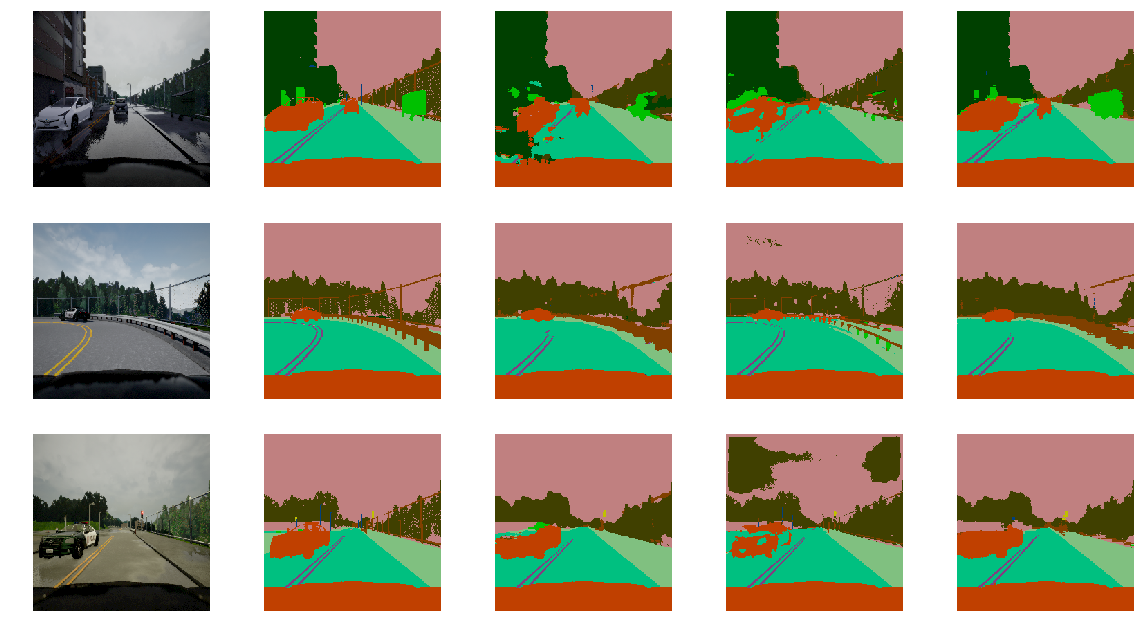

In [33]:

# making predictions for a set of images

import warnings
warnings.filterwarnings('ignore')

test_cases_img = ['path/test/image/02_00_225.png', 'path/test/image/10_00_215.png', 'path/test/image/F9-4.png']

test_cases_mask = ['path/test/mask/02_00_225.png', 'path/test/mask/10_00_215.png', 'path/test/mask/F9-4.png']

plt.figure(figsize = (20,50))
m = [model, model1, model2]

count = 0
for j,k in zip(test_cases_img, test_cases_mask):
    img = read_img(j)
    mask = read_mask(k)
    x1,y1 = prediction_visualization(m[0].predict(img[np.newaxis])[0], mask)
    x2,y2 = prediction_visualization(m[1].predict(img[np.newaxis])[0], mask)
    x3,y3 = prediction_visualization(m[2].predict(img[np.newaxis])[0], mask)
    
    plt.subplot(13,5,count*5+1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(13,5,count*5+2)
    plt.imshow(x1)
    plt.axis('off')
    plt.subplot(13,5,count*5+3)
    plt.imshow(y1)
    plt.axis('off')
    plt.subplot(13,5,count*5+4)
    plt.imshow(y2)
    plt.axis('off')
    plt.subplot(13,5,count*5+5)
    plt.imshow(y3)
    plt.axis('off')
    count = count +1


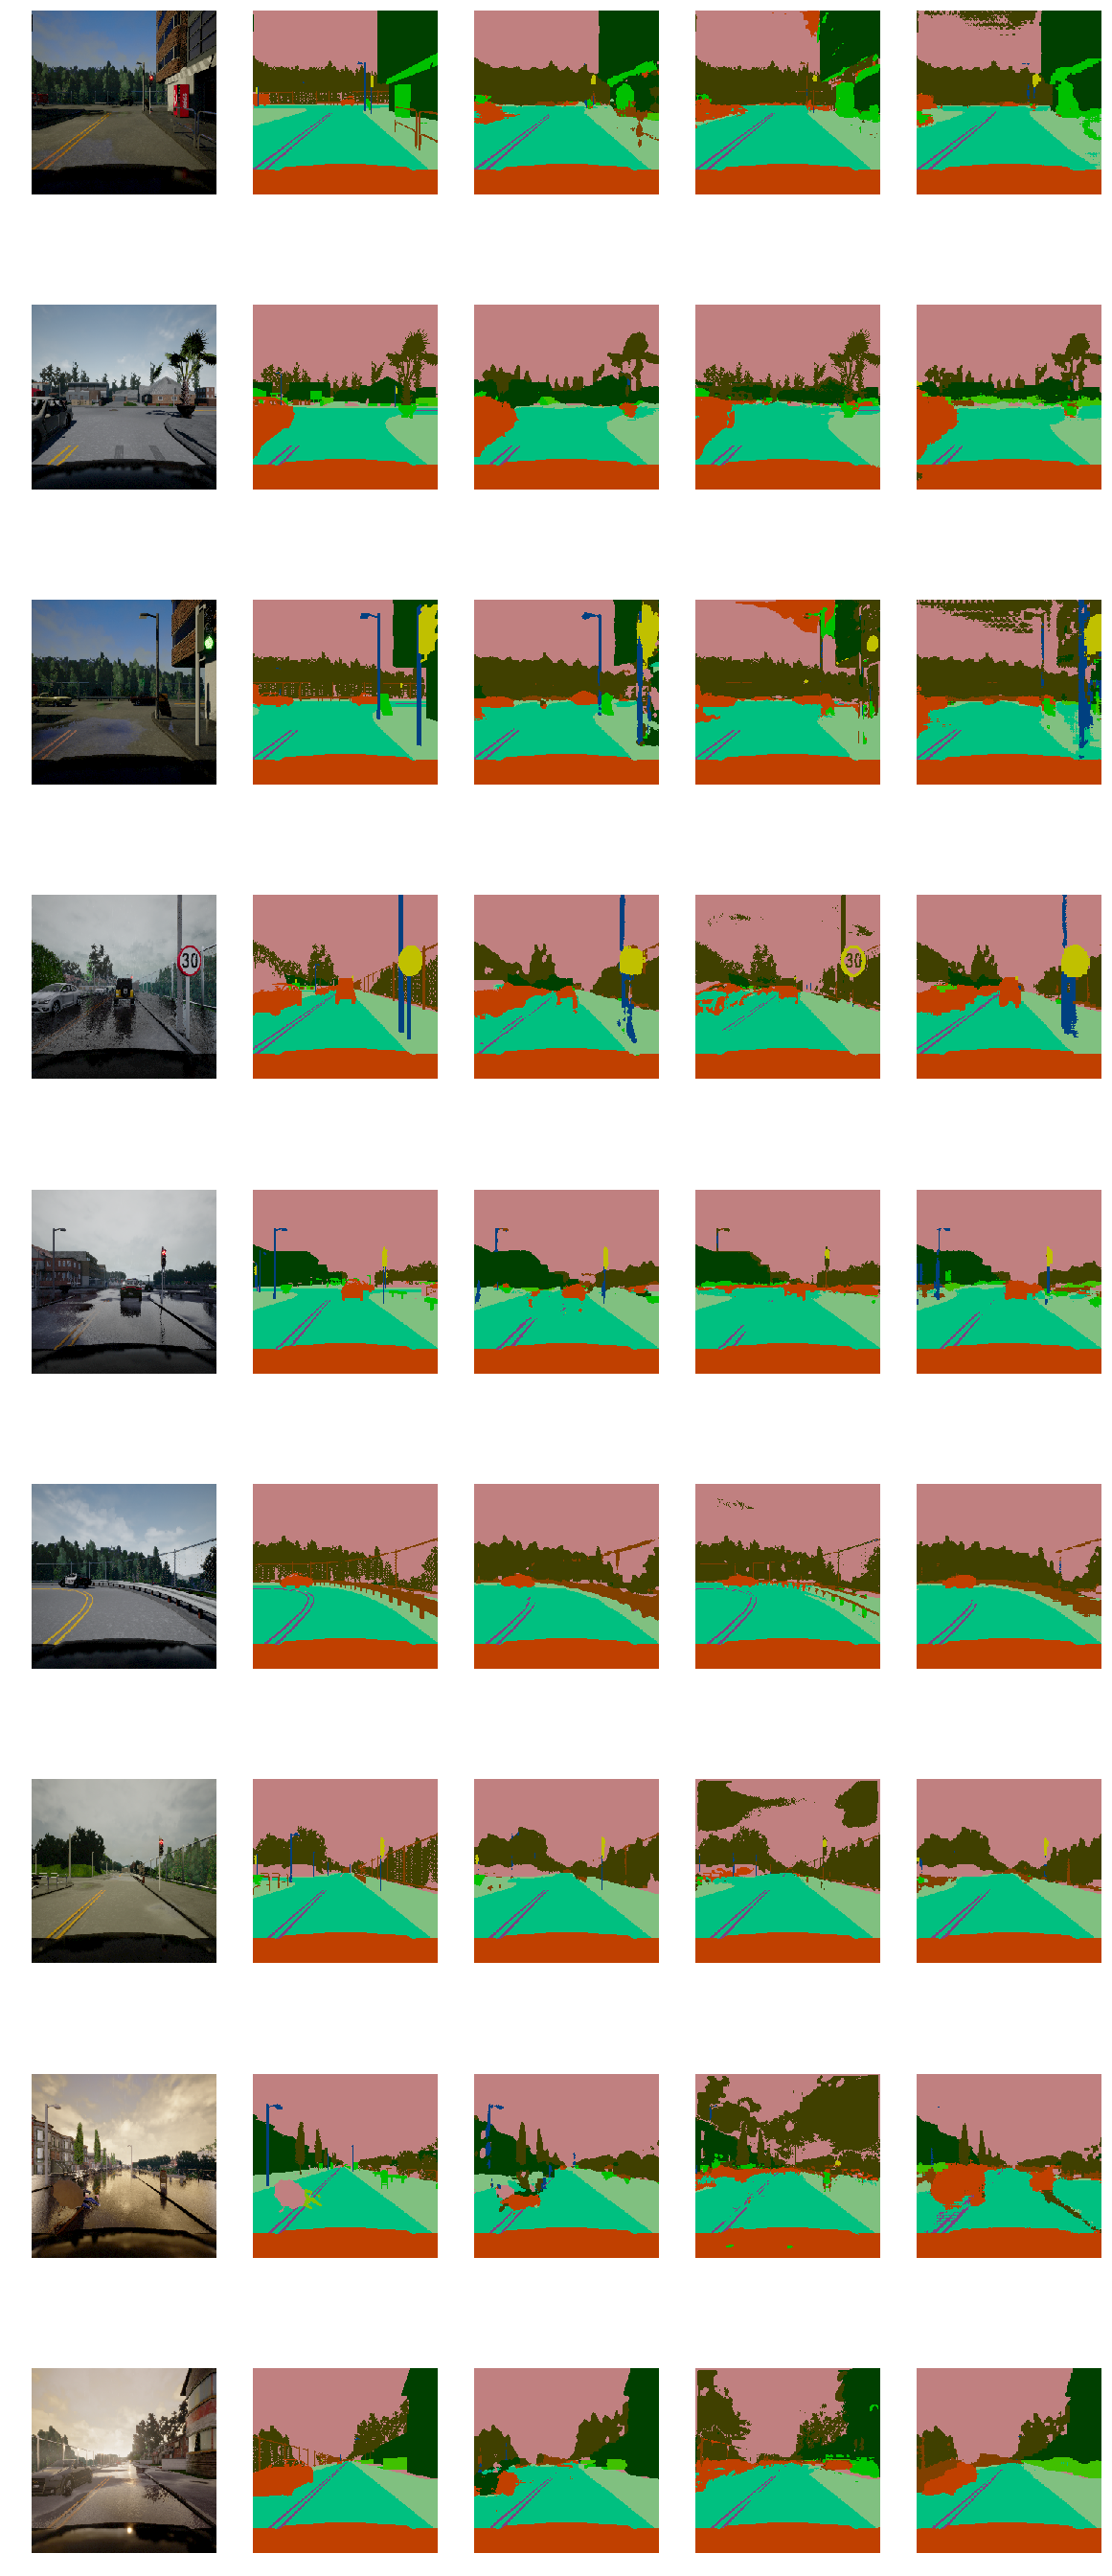

In [42]:
import warnings
warnings.filterwarnings('ignore')

test_cases_img = ['path/test/image/02_01_101.png',
 'path/test/image/F70-42.png',
 'path/test/image/02_01_155.png',
 'path/test/image/03_01_208.png',
 'path/test/image/09_00_168.png',
 'path/test/image/10_00_215.png',
'path/test/image/F9-52.png', 
'path/test/image/F65-63.png',
'path/test/image/F63-10.png']



test_cases_mask = ['path/test/mask/02_01_101.png',
 'path/test/mask/F70-42.png',
 'path/test/mask/02_01_155.png',
 'path/test/mask/03_01_208.png',
 'path/test/mask/09_00_168.png',
 'path/test/mask/10_00_215.png',
'path/test/mask/F9-52.png', 
'path/test/mask/F65-63.png',
'path/test/mask/F63-10.png']



plt.figure(figsize = (20,50))
m = [model, model1, model2]

count = 0
for j,k in zip(test_cases_img, test_cases_mask):
    img = read_img(j)
    mask = read_mask(k)
    x1,y1 = prediction_visualization(m[0].predict(img[np.newaxis])[0], mask)
    x2,y2 = prediction_visualization(m[1].predict(img[np.newaxis])[0], mask)
    x3,y3 = prediction_visualization(m[2].predict(img[np.newaxis])[0], mask)
    
    plt.subplot(9,5,count*5+1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(9,5,count*5+2)
    plt.imshow(x1)
    plt.axis('off')
    plt.subplot(9,5,count*5+3)
    plt.imshow(y1)
    plt.axis('off')
    plt.subplot(9,5,count*5+4)
    plt.imshow(y2)
    plt.axis('off')
    plt.subplot(9,5,count*5+5)
    plt.imshow(y3)
    plt.axis('off')
    count = count +1


# Results for CRFasRNN
The same pipeline as above is utilized to evaluate CRFasRNN

In [11]:
model3.load_weights('model_CRF_categorical_with_utilization_5+5+5_epochs_23103_Morphology_activation.h5')

In [14]:
#Calculating the classwise IoU for each testing image for each model

import warnings
warnings.filterwarnings('ignore')
from statistics import mean 
  
image_path = 'path/test/image/'
mask_path = 'path/test/mask/'

assert image_path[-1] == '/'
assert mask_path[-1] == '/'

images1 = glob.glob( image_path + "*.png"  ) 
images = [a.replace('\\', '/') for a in images1]
images.sort()
segmentations1  = glob.glob( mask_path + "*.png"  )
segmentations = [a.replace('\\', '/') for a in segmentations1]
segmentations.sort()

ti4 = []
iou4 = []

for i,j in zip(images ,segmentations):
    img = read_img(i)[np.newaxis]
    mask = read_mask(j)
    
    t0 = time.time()
    prediction1 = model3.predict(img)
    t1 = time.time()
    ti4.append(round(t1 - t0, 2))
    
  
    class_wise_iou_crf = calc_metric(13,mask , prediction3)
    iou4.append(class_wise_iou_crf)


In [47]:
#Class-wise IoU for CRF

class_iou_crf = list(pd.DataFrame(iou4).mean(axis=0))


class_wise_iou = pd.DataFrame({'CRF' : class_iou_crf}, 
                                columns=['CRF'], index=['Unlabelled', 'Building', 'Fence', 'Other', 
                                                                       'Pedestrian', 'Pole', 'Road Line', 'Road',
                                                                       'Side Walk', 'Vegetation', 'Car', 'Wall' ,
                                                                       'Traffic Sign'])
class_wise_iou

#There is no pedestrian that is why it is Zero

,CRF
Unlabelled,0.905670
Building,0.666588
Fence,0.198416
Other,0.223259
Pedestrian,0.000000
Pole,0.185436
Road Line,0.789676
Road,0.958949
Side Walk,0.821048
Vegetation,0.737007


In [2]:
#Average training time, prediction time, IoU and GPU Utlization is calculated for each model
crf_stats = pd.read_csv('CRF_GPU_STATS_Morphology')

Gpu_utilization_crf = mean(list(crf_stats['load_Gpu_1']))
Gpu_utilization = [Gpu_utilization_crf]

Average_training_time_CRF = mean([5272, 5138, 5141, 5144, 5145, 5141, 5139, 5141, 5141, 5137, 5138, 5137, 5141, 5139, 5137])/2
Average_training_time = [Average_training_time_CRF ]


iou_crf = mean(list(pd.DataFrame(iou4).mean(axis=0)))

mean_iou= [iou_crf]


Average_prediction_time_CRF = mean(ti4)
Average_prediction_time = [Average_prediction_time_CRF]

stats = pd.DataFrame({'Gpu_utilization' : Gpu_utilization,
                                'Average_training_time' : Average_training_time,
                                'mean_iou' : mean_iou ,
                     'Average_prediction_time': Average_prediction_time}, 
                    columns=['Gpu_utilization','Average_training_time', 'mean_iou','Average_prediction_time'],
                     index=['CRF'])
stats

,Gpu_utilization,Average_training_time,mean_iou,Average_prediction_time
CRF,21.476639,2574.366667,0.521203,1.194686


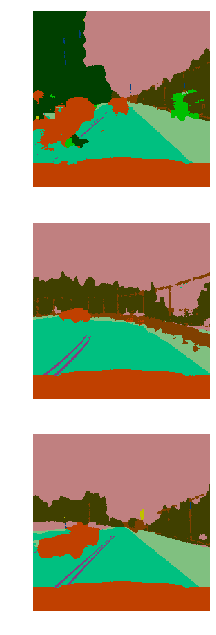

In [23]:
# Evaluating on test images
import warnings
warnings.filterwarnings('ignore')

test_cases_img = ['path/Project_split_data/test/image/02_00_225.png', 'path/Project_split_data/test/image/10_00_215.png', 'path/Project_split_data/test/image/F9-4.png']

test_cases_mask = ['path/Project_split_data/test/mask/02_00_225.png',  'path/Project_split_data/test/mask/10_00_215.png', 'path/Project_split_data/test/mask/F9-4.png']


plt.figure(figsize = (20,50))
m = [model3]

count = 0
for j,k in zip(test_cases_img, test_cases_mask):
    img = read_img(j)
    mask = read_mask(k)
    x1,y1 = prediction_visualization(m[0].predict(img[np.newaxis])[0], mask)
    
    plt.subplot(13,1,count+1)
    plt.imshow(y1)
    plt.axis('off')
    count = count +1



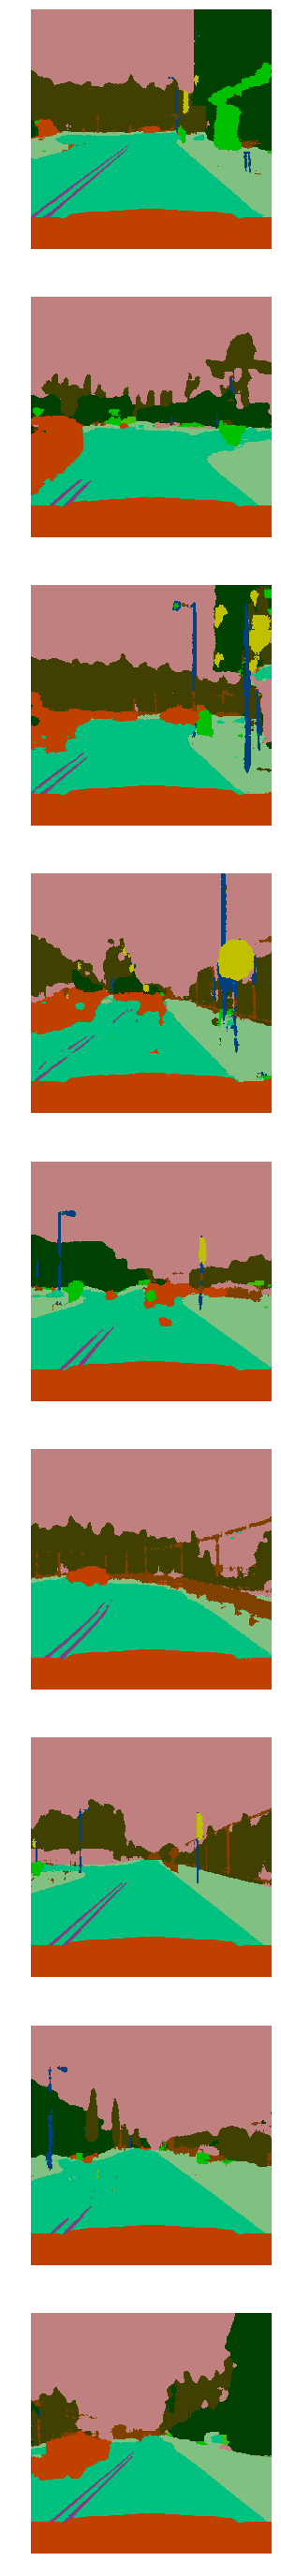

In [36]:
import warnings
warnings.filterwarnings('ignore')

test_cases_img = ['path/Project_split_data/test/image/02_01_101.png',
 'path/Project_split_data/test/image/F70-42.png',
 'path/Project_split_data/train/image/02_01_155.png',
 'path/Project_split_data/train/image/03_01_208.png',
 'path/Project_split_data/test/image/09_00_168.png',
 'path/Project_split_data/valid/image/10_00_215.png',
'path/Project_split_data/test/image/F9-52.png', 
'path/Project_split_data/test/image/F65-63.png',
'path/Project_split_data/test/image/F63-10.png']

test_cases_mask = ['path/Project_split_data/test/mask/02_01_101.png',
 'path/Project_split_data/test/mask/F70-42.png',
 'path/Project_split_data/train/mask/02_01_155.png',
 'path/Project_split_data/train/mask/03_01_208.png',
 'path/Project_split_data/test/mask/09_00_168.png',
 'path/Project_split_data/valid/mask/10_00_215.png',
'path/Project_split_data/test/mask/F9-52.png', 
'path/Project_split_data/test/mask/F65-63.png',
'path/Project_split_data/test/mask/F63-10.png']



plt.figure(figsize = (20,50))
m = [model3]

count = 0
for j,k in zip(test_cases_img, test_cases_mask):
    img = read_img(j)
    mask = read_mask(k)
    x1,y1 = prediction_visualization(m[0].predict(img[np.newaxis])[0], mask)
    
    plt.subplot(9,1,count+1)
    plt.imshow(y1)
    plt.axis('off')
    count = count +1



# Video Compilation

Since an autonomous vehicle requires to do segmentation for a video the four models were compared on their predictions on a small video of 10 sec. 



In [35]:
def vid_pipeline_FCN(img):
    global running_avg
    global index
    
    img = img.astype(np.float32)
    img = img/255.0
    img = cv2.resize(img, ( 256 , 256 ),interpolation=cv2.INTER_NEAREST)
    original = img
    img = img[np.newaxis]
    
    fake = np.zeros((  256 , 256  , 13))
    fa,img_new = prediction_visualization(model.predict(img)[0], fake)
    
    output = cv2.addWeighted((original*255).astype(np.uint8), 0.9, (img_new).astype(np.uint8), 1, 1)
    return output

In [38]:
def vid_pipeline_UNET(img):
    global running_avg
    global index
    
    img = img.astype(np.float32)
    img = img/255.0
    img = cv2.resize(img, ( 256 , 256 ),interpolation=cv2.INTER_NEAREST)
    original = img
    img = img[np.newaxis]
    
    fake = np.zeros((  256 , 256  , 13))
    fa,img_new = prediction_visualization(model1.predict(img)[0], fake)
    
    output = cv2.addWeighted((original*255).astype(np.uint8), 0.9, (img_new).astype(np.uint8), 1, 1)
    return output

In [37]:
def vid_pipeline_ENET(img):
    global running_avg
    global index
    
    img = img.astype(np.float32)
    img = img/255.0
    img = cv2.resize(img, ( 256 , 256 ),interpolation=cv2.INTER_NEAREST)
    original = img
    img = img[np.newaxis]
    
    fake = np.zeros((  256 , 256  , 13))
    fa,img_new = prediction_visualization(model2.predict(img)[0], fake)
    
    output = cv2.addWeighted((original*255).astype(np.uint8), 0.9, (img_new).astype(np.uint8), 1, 1)
    return output

In [25]:
def vid_pipeline_CRF(img):
    global running_avg
    global index
    
    img = img.astype(np.float32)
    img = img/255.0
    img = cv2.resize(img, ( 256 , 256 ),interpolation=cv2.INTER_NEAREST)
    original = img
    img = img[np.newaxis]
    
    fake = np.zeros((  256 , 256  , 13))
    fa,img_new = prediction_visualization(model3.predict(img)[0], fake)
    
    output = cv2.addWeighted((original*255).astype(np.uint8), 0.9, (img_new).astype(np.uint8), 1, 1)
    return output

In [36]:
from moviepy.editor import VideoFileClip
myclip = VideoFileClip('V1.mp4')
output_vid = 'output_FCN.mp4'
clip = myclip.fl_image(vid_pipeline_FCN)
clip.write_videofile(output_vid, audio=False)

Moviepy - Building video output_FCN.mp4.
Moviepy - Writing video output_FCN.mp4



Moviepy - Done !
Moviepy - video ready output_FCN.mp4


In [39]:
myclip = VideoFileClip('V1.mp4')
output_vid = 'output_ENET.mp4'
clip = myclip.fl_image(vid_pipeline_ENET)
clip.write_videofile(output_vid, audio=False)

Moviepy - Building video output_ENET.mp4.
Moviepy - Writing video output_ENET.mp4



Moviepy - Done !
Moviepy - video ready output_ENET.mp4


In [40]:
myclip = VideoFileClip('V1.mp4')
output_vid = 'output_UNET.mp4'
clip = myclip.fl_image(vid_pipeline_UNET)
clip.write_videofile(output_vid, audio=False)

Moviepy - Building video output_UNET.mp4.
Moviepy - Writing video output_UNET.mp4



Moviepy - Done !
Moviepy - video ready output_UNET.mp4


In [30]:
from moviepy.editor import VideoFileClip
myclip = VideoFileClip('V1.mp4')
output_vid = 'output_CRF.mp4'
clip = myclip.fl_image(vid_pipeline_CRF)
clip.write_videofile(output_vid, audio=False)

t:   0%|          | 0/192 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_CRF.mp4.
Moviepy - Writing video output_CRF.mp4



Moviepy - Done !
Moviepy - video ready output_CRF.mp4


### Creating the Label Legend for the Video

(-0.5, 299.5, 609.5, -0.5)

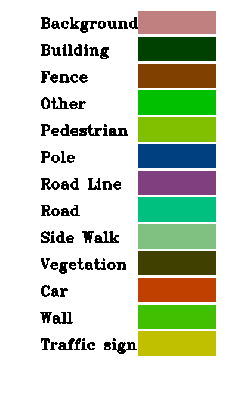

In [34]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(25, 6), dpi=80, facecolor='w', edgecolor='k')
COLORS = colors
#https://carla.readthedocs.io/en/latest/cameras_and_sensors/#camera-semantic-segmentation
CLASSES =['Background','Building','Fence','Other','Pedestrian','Pole', 'Road Line', 'Road', 'Side Walk', 'Vegetation', 'Car', 'Wall', 'Traffic sign'] 
# initialize the legend visualization
legend = np.ones(((len(CLASSES) * 45)+25, 300, 3), dtype="uint8")
legend = legend*255
 
# loop over the class names + colors
for (i, (className, color)) in enumerate(zip(CLASSES, COLORS)):
	# draw the class name + color on the legend
	color = [int(c) for c in color]
	cv2.putText(legend, className, (5, (i * 45) + 30), cv2.FONT_HERSHEY_TRIPLEX, 0.8, (0, 0, 0), 2)
	cv2.rectangle(legend, (300, (i * 45)), (170, (i * 45) + 40),tuple(color), -1)
plt.imshow(legend)
plt.axis('off')

> References
<br>[1] https://github.com/davidtvs/Keras-LinkNet/blob/master/metrics/miou.py
<br>[2]https://github.com/sadeepj/crfasrnn_keras/tree/master/src